In [1]:
import numpy as np
import pandas as pd

from datetime import datetime

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.cluster import KMeans

import wrangle as wr
import preprocessing as pr
import explore as ex
import model as mo

import warnings
warnings.filterwarnings("ignore")


Bad key "text.kerning_factor" on line 4 in
/usr/local/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
pd.set_option("display.max_columns", None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
plt.rc("figure", figsize=(16, 8))

In [3]:
# Helper function used to updated the scaled arrays and transform them into usable dataframes
def return_values(scaler, df):
    scaled_df = pd.DataFrame(scaler.transform(df), columns=df.columns.values).set_index([df.index.values])
    return scaler, scaled_df

# Linear scaler
def min_max_scaler(df):
    scaler = MinMaxScaler().fit(df)
    scaler, scaled_df = return_values(scaler, df)
    return scaler, scaled_df

In [4]:
def labeling_future_data(df):
    """this function takes in a data frame and returns a boolean column that identifies
    if a city_state_year is a market that should be entered"""
    
    df["label_quantity_of_mortgages_pop_2y"] = (df.sort_values(["year"])
                                  .groupby(["city", "state"])[["quantity_of_mortgages_pop"]]
                                  .pct_change(2)
                                  .shift(-2))
    
    df["label_total_mortgage_volume_pop_2y"] = (df.sort_values(["year"])
                                  .groupby(["city", "state"])[["total_mortgage_volume_pop"]]
                                  .pct_change(2)
                                  .shift(-2))
    
    Q3 = df.label_quantity_of_mortgages_pop_2y.quantile(.75)
    
    Q1 = df.label_quantity_of_mortgages_pop_2y.quantile(.25)
    
    upper_fence_quantity = Q3 + ((Q3-Q1)*1.5)
    
    Q3 = df.label_total_mortgage_volume_pop_2y.quantile(.75)
    
    Q1 = df.label_total_mortgage_volume_pop_2y.quantile(.25)
    
    upper_fence_volume = Q3 + ((Q3-Q1)*1.5)
    
    df['should_enter'] = (df.label_total_mortgage_volume_pop_2y > upper_fence_volume) | (df.label_quantity_of_mortgages_pop_2y > upper_fence_quantity)
    
    return df

In [5]:
df = wr.wrangle_hud()
df

,fha_number,project_name,project_city,project_state,basic_fha_risk_share_or_other,program_category,activity_description,activity_group,facility_type,program_designation,firm_commitment_activity,lender_at_firm_commitment_activity,mortgage_at_time_of_firm_commitment_issuance_amendment_or_reissuance,unit_or_bed_count,date_of_firm_commitment_activity,fiscal_year_of_firm_commitment_activity,mortgage_at_firm_commitment_issuance,date_of_firm_issue,fiscal_year_of_firm_commitment,map_or_tap,lihtc_designation,tax_exempt_bond_designation,home_designation,cdbg_designation,section_202_refi_designation,irp_decoupling_designation,hope_vi_designation,current_status,final_mortgage_amount,is_refinance,is_new_construction
0,11345004,Western Heights Apartments,Olney,TX,Basic FHA,223a7 Refi Apts,Refinance,Refi/ Pchse,Apts,a7/236,Firm Issued,GREYSTONE SERVICING COMPANY LLC,277600,48,2005-10-01,2006,277600,2005-10-01,2006,TAP,False,False,False,False,False,False,False,Firm Comit then Owner Withdrew,271700,True,False
1,11345005,Woodlands Village Apts,Breckenridge,TX,Basic FHA,223a7 Refi Apts,Refinance,Refi/ Pchse,Apts,a7/236,Firm Issued,GREYSTONE SERVICING COMPANY LLC,173000,88,2005-10-01,2006,173000,2005-10-01,2006,TAP,False,False,False,False,False,False,False,Finally Endorsed,168300,True,False
2,4235583,Harbor Court Apartments,Rocky River,OH,Basic FHA,223a7 Refi Apts,Refinance,Refi/ Pchse,Apts,a7/221d4,Firm Issued,GREYSTONE SERVICING COMPANY LLC,3886800,120,2005-10-03,2006,3886800,2005-10-03,2006,TAP,False,False,False,False,False,False,False,Finally Endorsed,3886800,True,False
3,3297260,Compton Towne Apartments,Wilmington,DE,Risk Sharing,QPE Risk Sharing,Refinance,Refi/ Pchse,Coop/Apts/Mobile Home Pk/ALF,QPE Risk Shg Existing,Firm Issued,FEDERAL NATIONAL MORTGAGE,4000000,76,2005-10-03,2006,4000000,2005-10-03,2006,TAP,True,False,False,False,False,False,False,Finally Endorsed,4000000,True,False
4,7135779,Evergreen Terrace I,Joliet,IL,Basic FHA,223a7 Refi Apts,Refinance,Refi/ Pchse,Apts,a7/221d4,Firm Issued,REILLY MORTGAGE GRP,5129000,241,2005-10-04,2006,5129000,2005-10-04,2006,TAP,False,False,False,False,False,False,False,Firm Expired,5247700,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19597,2398371,Central Building,Worcester,MA,Risk Sharing,HFA Risk Sharing,Refinance,Refi/ Pchse,Coop/Apts/Mobile Home Pk/ALF,HFA Risk Shg FFB Existing,Firm Reissued,MASSACHUSETTS HFA,3717000,55,2019-02-15,2019,3717000,2019-02-15,2019,TAP,False,False,False,False,False,False,False,Finally Endorsed,3717000,True,False
19852,5235809,Memorial Apartments,Baltimore,MD,Basic FHA,223a7 Refi Apts,Refinance,Refi/ Pchse,Apts,a7/221d4,Firm Reissued,ORIX REAL ESTATE CAPITAL LLC,13950900,266,2019-05-02,2019,13950900,2019-05-02,2019,MAP,True,False,False,False,False,False,False,Finally Endorsed,13852700,True,False
20171,4711238,PINERY PARK APARTMENTS,Wyoming,MI,Basic FHA,223f Refi/Purchase Apts,Purchase,Refi/ Pchse,Apts/Coops,223f Apts,Firm Reissued,DAVIS-PENN MTGE,6372000,125,2019-08-22,2019,6372000,2019-08-22,2019,MAP,False,False,False,False,False,False,False,Finally Endorsed,6372000,False,False
20174,4711239,TAMARISK APARTMENTS,Kentwood,MI,Basic FHA,223f Refi/Purchase Apts,Purchase,Refi/ Pchse,Apts/Coops,223f Apts,Firm Reissued,DAVIS-PENN MTGE,4779000,100,2019-08-22,2019,4779000,2019-08-22,2019,MAP,False,False,False,False,False,False,False,Finally Endorsed,4779000,False,False


In [6]:
# df.unit_or_bed_count.min(), df.unit_or_bed_count.max()

In [7]:
# units = df.groupby(["project_city", "project_state", "fiscal_year_of_firm_commitment_activity"])[
#         "unit_or_bed_count"
#     ].agg(["sum", "mean", "median"]).sort_values(
#         by=["sum"], ascending=False
#     ).reset_index()

# units

In [8]:
# units.rename(
#         columns={
#             "project_city": "city",
#             "project_state": "state",
#             "fiscal_year_of_firm_commitment_activity": "year",
#             "sum": "quantity_of_units",
#             "mean": "average_number_of_units",
#             "median": "median_number_of_units",
#         },
#         inplace=True,
#     )

In [9]:
# units

In [10]:
# testing the updated get_model_df function
model_df = pr.get_model_df()

In [11]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13507 entries, 0 to 13506
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   city                         13507 non-null  object 
 1   state                        13507 non-null  object 
 2   year                         13507 non-null  int64  
 3   quantity_of_mortgages_pop    13507 non-null  int64  
 4   total_mortgage_volume_pop    13507 non-null  int64  
 5   average_mortgage_volume_pop  13507 non-null  float64
 6   median_mortgage_amount_pop   13507 non-null  float64
 7   quantity_of_mortgages_nc     2055 non-null   float64
 8   total_mortgage_volume_nc     2055 non-null   float64
 9   average_mortgage_volume_nc   2055 non-null   float64
 10  median_mortgage_amount_nc    2055 non-null   float64
 11  label                        13507 non-null  bool   
dtypes: bool(1), float64(6), int64(3), object(2)
memory usage: 1.2+ MB


In [12]:
model_df["quantity_of_mortgages_nc"] = model_df.quantity_of_mortgages_nc.fillna(0.001)

model_df["total_mortgage_volume_nc"] = model_df.total_mortgage_volume_nc.fillna(0.001)

model_df["average_mortgage_volume_nc"] = model_df.average_mortgage_volume_nc.fillna(0.001)

model_df["median_mortgage_amount_nc"] = model_df.median_mortgage_amount_nc.fillna(0.001)

model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13507 entries, 0 to 13506
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   city                         13507 non-null  object 
 1   state                        13507 non-null  object 
 2   year                         13507 non-null  int64  
 3   quantity_of_mortgages_pop    13507 non-null  int64  
 4   total_mortgage_volume_pop    13507 non-null  int64  
 5   average_mortgage_volume_pop  13507 non-null  float64
 6   median_mortgage_amount_pop   13507 non-null  float64
 7   quantity_of_mortgages_nc     13507 non-null  float64
 8   total_mortgage_volume_nc     13507 non-null  float64
 9   average_mortgage_volume_nc   13507 non-null  float64
 10  median_mortgage_amount_nc    13507 non-null  float64
 11  label                        13507 non-null  bool   
dtypes: bool(1), float64(6), int64(3), object(2)
memory usage: 1.2+ MB


In [13]:
# calling add_new_features that Daniel created
model_df = pr.add_new_features(model_df)
print(model_df.shape)

(13507, 19)


In [14]:
model_df

,city,state,year,quantity_of_mortgages_pop,total_mortgage_volume_pop,average_mortgage_volume_pop,median_mortgage_amount_pop,quantity_of_mortgages_nc,total_mortgage_volume_nc,average_mortgage_volume_nc,median_mortgage_amount_nc,label,city_state_vol_delta_pop,city_state_vol_delta_nc,city_state_qty_delta_pop,city_state_qty_delta_nc,market_volume,market_volume_delta,ei
7735,Abbeville,LA,2013,1,6500000,6500000.00000,6500000.00000,0.00100,0.00100,0.00100,0.00100,False,nan,nan,nan,nan,24940177380,nan,nan
12512,Abbeville,SC,2008,1,1552900,1552900.00000,1552900.00000,0.00100,0.00100,0.00100,0.00100,False,nan,nan,nan,nan,4444102426,-0.82181,nan
7500,Aberdeen,MD,2006,2,6828000,3414000.00000,3414000.00000,0.00100,0.00100,0.00100,0.00100,False,nan,nan,nan,nan,6774129256,nan,nan
1410,Aberdeen,MD,2013,3,34075100,11358366.66667,4639800.00000,1.00000,27247100.00000,27247100.00000,27247100.00000,False,3.99050,27247099999.00000,0.50000,999.00000,24940177380,2.68168,1.35549
7710,Aberdeen,MD,2015,1,6525000,6525000.00000,6525000.00000,0.00100,0.00100,0.00100,0.00100,False,-0.80851,-1.00000,-0.66667,-0.99900,13569931547,-0.45590,0.35194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6640,Zion,IL,2020,1,8293200,8293200.00000,8293200.00000,0.00100,0.00100,0.00100,0.00100,False,-0.55737,0.00000,0.00000,0.00000,11266041100,-0.36526,0.69735
5364,Zionsville,IN,2012,1,11000000,11000000.00000,11000000.00000,0.00100,0.00100,0.00100,0.00100,False,nan,nan,nan,nan,21797876931,0.93483,nan
2146,Zionsville,IN,2014,1,25323200,25323200.00000,25323200.00000,0.00100,0.00100,0.00100,0.00100,False,1.30211,0.00000,0.00000,0.00000,16405588955,-0.24738,3.05878
8516,Zionsville,IN,2015,1,5500000,5500000.00000,5500000.00000,0.00100,0.00100,0.00100,0.00100,False,-0.78281,0.00000,0.00000,0.00000,13569931547,-0.17285,0.26258


In [15]:
# creating city_state ID
model_df["city_state"] = model_df["city"] + "_" + model_df["state"]

# creating city_mask varible using the value counts of the years for each city_state
city_mask = model_df.groupby("city_state").year.count()

# masking the city_mask variable to only include city_states where there are 15 year observations
# by doing this we ensure that we are working with city_states that have data for 2006-2020 Q2 
city_mask = city_mask[city_mask == 15]

# write a function to shrink the df
def in_city_mask(x):
    return x in city_mask

# apply city mask to shrink the df
model_df = model_df[model_df.city_state.apply(in_city_mask)]

# sort_values of model_df by city, state, and year
model_df = model_df.sort_values(["city", "state", "year"])

# reseting index
model_df.reset_index(inplace=True)

# drop original index
model_df.drop(columns=["index"], inplace=True)
print(model_df.shape)
model_df.head(16)

(390, 20)


,city,state,year,quantity_of_mortgages_pop,total_mortgage_volume_pop,average_mortgage_volume_pop,median_mortgage_amount_pop,quantity_of_mortgages_nc,total_mortgage_volume_nc,average_mortgage_volume_nc,median_mortgage_amount_nc,label,city_state_vol_delta_pop,city_state_vol_delta_nc,city_state_qty_delta_pop,city_state_qty_delta_nc,market_volume,market_volume_delta,ei,city_state
0,Atlanta,GA,2006,6,33186800,5531133.33333,4457100.00000,2.00000,9181100.00000,4590550.00000,4590550.00000,False,nan,nan,nan,nan,6774129256,nan,nan,Atlanta_GA
1,Atlanta,GA,2007,8,28277600,3534700.00000,3031150.00000,2.00000,4541700.00000,2270850.00000,2270850.00000,False,-0.14793,-0.50532,0.33333,0.00000,4973263164,-0.26584,1.16062,Atlanta_GA
2,Atlanta,GA,2008,2,6735000,3367500.00000,3367500.00000,1.00000,4950000.00000,4950000.00000,4950000.00000,False,-0.76183,0.08990,-0.75000,-0.50000,4444102426,-0.10640,0.26653,Atlanta_GA
3,Atlanta,GA,2009,9,49972900,5552544.44444,4400000.00000,1.00000,3750000.00000,3750000.00000,3750000.00000,False,6.41988,-0.24242,3.50000,0.00000,7882704846,0.77375,4.18317,Atlanta_GA
4,Atlanta,GA,2010,11,68788385,6253489.54545,5196100.00000,2.00000,7203500.00000,3601750.00000,3601750.00000,False,0.37651,0.92093,0.22222,1.00000,16193901958,1.05436,0.67005,Atlanta_GA
5,Atlanta,GA,2011,10,56215900,5621590.00000,4341850.00000,2.00000,9274500.00000,4637250.00000,4637250.00000,False,-0.18277,0.28750,-0.09091,0.00000,17502078323,0.08078,0.75615,Atlanta_GA
6,Atlanta,GA,2012,12,56365900,4697158.33333,3250100.00000,1.00000,3000000.00000,3000000.00000,3000000.00000,False,0.00267,-0.67653,0.20000,-0.50000,21797876931,0.24545,0.80507,Atlanta_GA
7,Atlanta,GA,2013,19,138582800,7293831.57895,6133600.00000,0.00100,0.00100,0.00100,0.00100,False,1.45863,-1.00000,0.58333,-0.99900,24940177380,0.14416,2.14886,Atlanta_GA
8,Atlanta,GA,2014,11,106803300,9709390.90909,4919700.00000,1.00000,15861400.00000,15861400.00000,15861400.00000,False,-0.22932,15861399999.00000,-0.42105,999.00000,16405588955,-0.34220,1.17161,Atlanta_GA
9,Atlanta,GA,2015,4,20900000,5225000.00000,5750000.00000,1.00000,5500000.00000,5500000.00000,5500000.00000,False,-0.80431,-0.65325,-0.63636,0.00000,13569931547,-0.17285,0.23658,Atlanta_GA


In [16]:
model_df = labeling_future_data(model_df)
model_df.head()

,city,state,year,quantity_of_mortgages_pop,total_mortgage_volume_pop,average_mortgage_volume_pop,median_mortgage_amount_pop,quantity_of_mortgages_nc,total_mortgage_volume_nc,average_mortgage_volume_nc,median_mortgage_amount_nc,label,city_state_vol_delta_pop,city_state_vol_delta_nc,city_state_qty_delta_pop,city_state_qty_delta_nc,market_volume,market_volume_delta,ei,city_state,label_quantity_of_mortgages_pop_2y,label_total_mortgage_volume_pop_2y,should_enter
0,Atlanta,GA,2006,6,33186800,5531133.33333,4457100.00000,2.00000,9181100.00000,4590550.00000,4590550.00000,False,nan,nan,nan,nan,6774129256,nan,nan,Atlanta_GA,nan,nan,False
1,Atlanta,GA,2007,8,28277600,3534700.00000,3031150.00000,2.00000,4541700.00000,2270850.00000,2270850.00000,False,-0.14793,-0.50532,0.33333,0.00000,4973263164,-0.26584,1.16062,Atlanta_GA,nan,nan,False
2,Atlanta,GA,2008,2,6735000,3367500.00000,3367500.00000,1.00000,4950000.00000,4950000.00000,4950000.00000,False,-0.76183,0.08990,-0.75000,-0.50000,4444102426,-0.10640,0.26653,Atlanta_GA,0.00000,-0.81291,False
3,Atlanta,GA,2009,9,49972900,5552544.44444,4400000.00000,1.00000,3750000.00000,3750000.00000,3750000.00000,False,6.41988,-0.24242,3.50000,0.00000,7882704846,0.77375,4.18317,Atlanta_GA,4.50000,9.21357,True
4,Atlanta,GA,2010,11,68788385,6253489.54545,5196100.00000,2.00000,7203500.00000,3601750.00000,3601750.00000,False,0.37651,0.92093,0.22222,1.00000,16193901958,1.05436,0.67005,Atlanta_GA,4.50000,14.07604,True


$H_0$: The mean new construction mortgage volume for markets labeled "to enter" is the same as markets labeled as "do not enter"

$H_a$: The mean new construction mortgage volume for markets labeled "to enter" is different from markets labeled as "do not enter"

In [17]:
alpha = .01

enter = model_df[model_df.should_enter == True].total_mortgage_volume_nc
dont_enter = model_df[model_df.should_enter == False].total_mortgage_volume_nc

tstat, pvalue = stats.ttest_ind(enter, dont_enter)

print(f"statistic = {tstat}")
print(f"  p-value = {pvalue}")
print()
if pvalue < alpha:
    print("Reject null hypothesis")
else:
    print("Fail to reject null hypothesis")

statistic = 0.2897935732118485
  p-value = 0.7721289654797853

Fail to reject null hypothesis


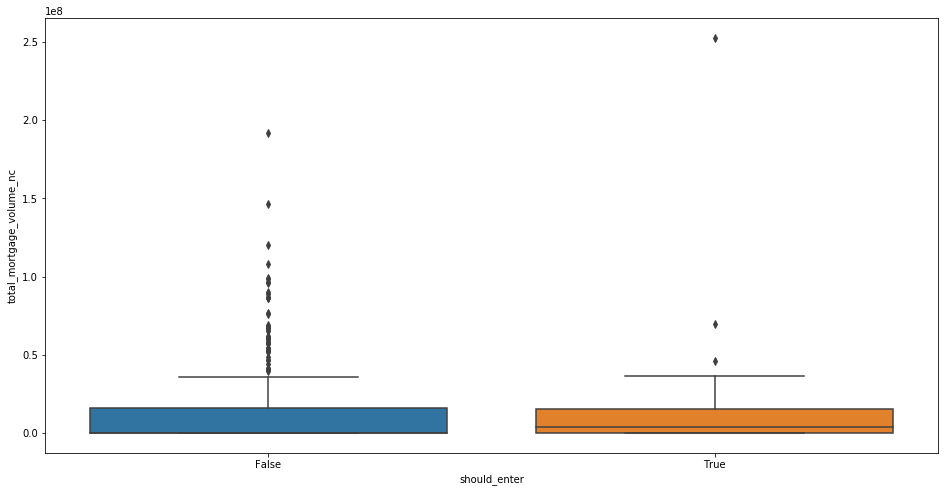

In [18]:
sns.boxplot(data=model_df, x="should_enter", y="total_mortgage_volume_nc")

In [19]:
atl = model_df[((model_df.city == "Atlanta") & (model_df.state == "GA"))]
atl

,city,state,year,quantity_of_mortgages_pop,total_mortgage_volume_pop,average_mortgage_volume_pop,median_mortgage_amount_pop,quantity_of_mortgages_nc,total_mortgage_volume_nc,average_mortgage_volume_nc,median_mortgage_amount_nc,label,city_state_vol_delta_pop,city_state_vol_delta_nc,city_state_qty_delta_pop,city_state_qty_delta_nc,market_volume,market_volume_delta,ei,city_state,label_quantity_of_mortgages_pop_2y,label_total_mortgage_volume_pop_2y,should_enter
0,Atlanta,GA,2006,6,33186800,5531133.33333,4457100.00000,2.00000,9181100.00000,4590550.00000,4590550.00000,False,nan,nan,nan,nan,6774129256,nan,nan,Atlanta_GA,nan,nan,False
1,Atlanta,GA,2007,8,28277600,3534700.00000,3031150.00000,2.00000,4541700.00000,2270850.00000,2270850.00000,False,-0.14793,-0.50532,0.33333,0.00000,4973263164,-0.26584,1.16062,Atlanta_GA,nan,nan,False
2,Atlanta,GA,2008,2,6735000,3367500.00000,3367500.00000,1.00000,4950000.00000,4950000.00000,4950000.00000,False,-0.76183,0.08990,-0.75000,-0.50000,4444102426,-0.10640,0.26653,Atlanta_GA,0.00000,-0.81291,False
3,Atlanta,GA,2009,9,49972900,5552544.44444,4400000.00000,1.00000,3750000.00000,3750000.00000,3750000.00000,False,6.41988,-0.24242,3.50000,0.00000,7882704846,0.77375,4.18317,Atlanta_GA,4.50000,9.21357,True
4,Atlanta,GA,2010,11,68788385,6253489.54545,5196100.00000,2.00000,7203500.00000,3601750.00000,3601750.00000,False,0.37651,0.92093,0.22222,1.00000,16193901958,1.05436,0.67005,Atlanta_GA,4.50000,14.07604,True
5,Atlanta,GA,2011,10,56215900,5621590.00000,4341850.00000,2.00000,9274500.00000,4637250.00000,4637250.00000,False,-0.18277,0.28750,-0.09091,0.00000,17502078323,0.08078,0.75615,Atlanta_GA,0.20000,0.00558,False
6,Atlanta,GA,2012,12,56365900,4697158.33333,3250100.00000,1.00000,3000000.00000,3000000.00000,3000000.00000,False,0.00267,-0.67653,0.20000,-0.50000,21797876931,0.24545,0.80507,Atlanta_GA,14.00000,4.58144,True
7,Atlanta,GA,2013,19,138582800,7293831.57895,6133600.00000,0.00100,0.00100,0.00100,0.00100,False,1.45863,-1.00000,0.58333,-0.99900,24940177380,0.14416,2.14886,Atlanta_GA,0.25000,1.54132,False
8,Atlanta,GA,2014,11,106803300,9709390.90909,4919700.00000,1.00000,15861400.00000,15861400.00000,15861400.00000,False,-0.22932,15861399999.00000,-0.42105,999.00000,16405588955,-0.34220,1.17161,Atlanta_GA,-0.23077,-0.46382,False
9,Atlanta,GA,2015,4,20900000,5225000.00000,5750000.00000,1.00000,5500000.00000,5500000.00000,5500000.00000,False,-0.80431,-0.65325,-0.63636,0.00000,13569931547,-0.17285,0.23658,Atlanta_GA,0.16667,-0.44485,False


In [20]:
atl.city_state_vol_delta_nc.round(2)

0                  nan
1             -0.51000
2              0.09000
3             -0.24000
4              0.92000
5              0.29000
6             -0.68000
7             -1.00000
8    15861399999.00000
9             -0.65000
10             0.88000
11             7.36000
12            -1.00000
13   15557699999.00000
14             0.38000
Name: city_state_vol_delta_nc, dtype: float64

In [21]:
# scaler = MinMaxScaler()
# scaler.fit(atl[["total_mortgage_volume_nc", "city_state_vol_delta_nc"]])
# atl[["total_mortgage_volume_nc", "city_state_vol_delta_nc"]] = scaler.transform(atl[["total_mortgage_volume_nc", "city_state_vol_delta_nc"]])

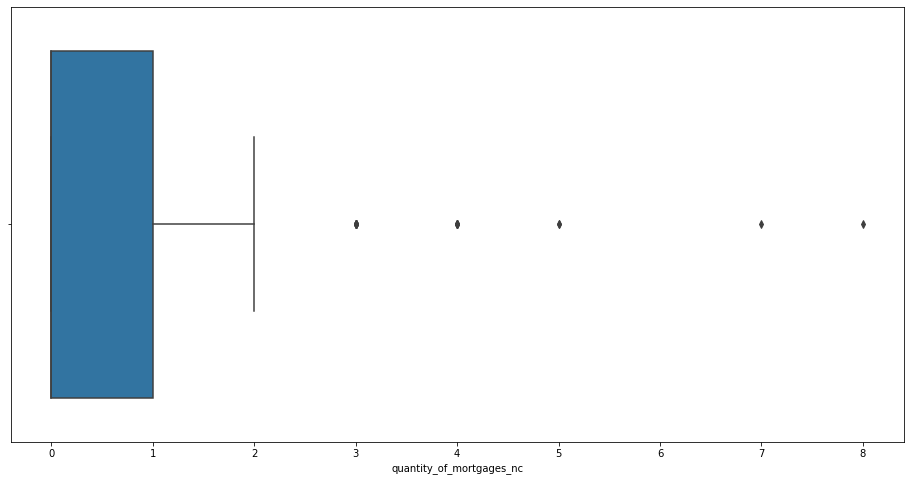

In [22]:
sns.boxplot(data=model_df, x="quantity_of_mortgages_nc")

In [23]:
# model_df.quantity_of_mortgages_nc.apply(lambda x: x > 1, 2, x)

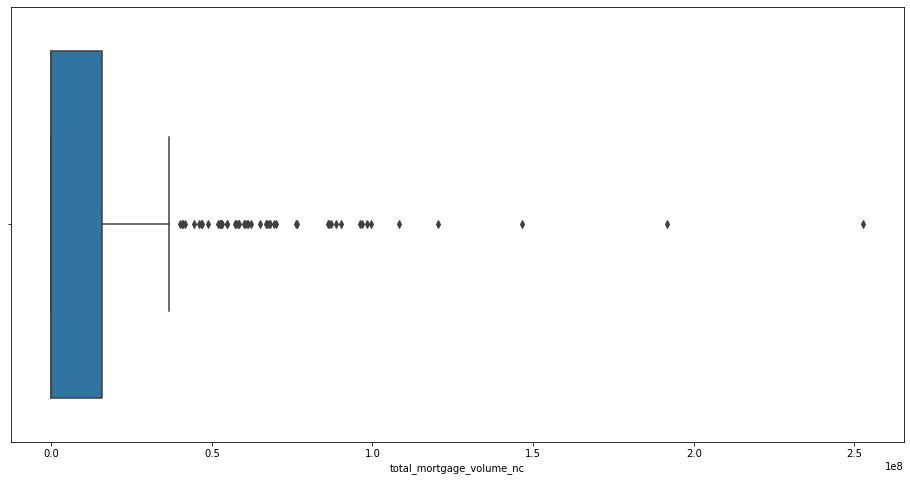

In [24]:
sns.boxplot(data=model_df, x="total_mortgage_volume_nc")

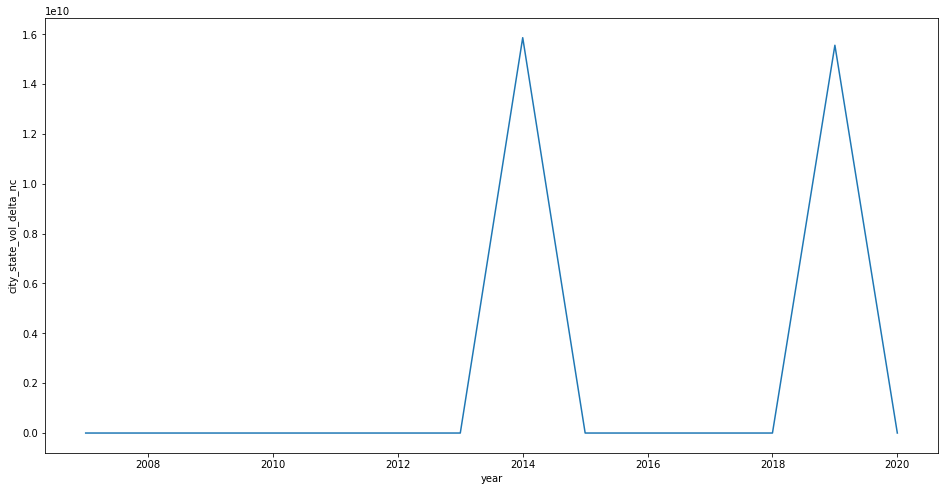

In [25]:
sns.lineplot(data=atl, x="year", y="city_state_vol_delta_nc")

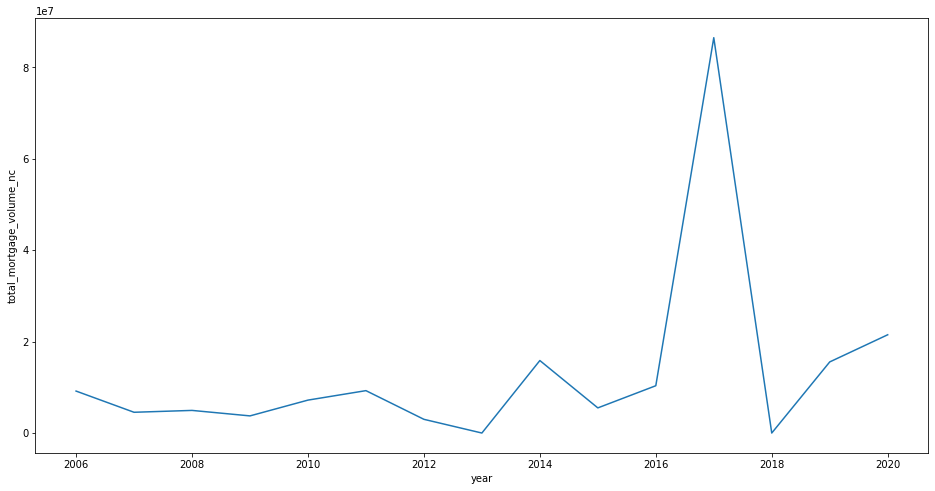

In [26]:
sns.lineplot(data=atl, x="year", y="total_mortgage_volume_nc")

In [27]:
model_df = pr.get_model_df()

model_df = pr.add_new_features(model_df)
print(model_df.shape)

(13507, 19)


In [28]:
# creating city_state ID
model_df["city_state"] = model_df["city"] + "_" + model_df["state"]

# creating city_mask varible using the value counts of the years for each city_state
city_mask = model_df.groupby("city_state").year.count()

# masking the city_mask variable to only include city_states where there are 15 year observations
# by doing this we ensure that we are working with city_states that have data for 2006-2020 Q2 
city_mask = city_mask[city_mask == 15]

# write a function to shrink the df
def in_city_mask(x):
    return x in city_mask

# apply city mask to shrink the df
model_df = model_df[model_df.city_state.apply(in_city_mask)]

# sort_values of model_df by city, state, and year
model_df = model_df.sort_values(["city", "state", "year"])

# reseting index
model_df.reset_index(inplace=True)

# drop original index
model_df.drop(columns=["index"], inplace=True)
print(model_df.shape)
model_df.head(16)

(390, 20)


,city,state,year,quantity_of_mortgages_pop,total_mortgage_volume_pop,average_mortgage_volume_pop,median_mortgage_amount_pop,quantity_of_mortgages_nc,total_mortgage_volume_nc,average_mortgage_volume_nc,median_mortgage_amount_nc,label,city_state_vol_delta_pop,city_state_vol_delta_nc,city_state_qty_delta_pop,city_state_qty_delta_nc,market_volume,market_volume_delta,ei,city_state
0,Atlanta,GA,2006,6,33186800,5531133.33333,4457100.00000,2.00000,9181100.00000,4590550.00000,4590550.00000,False,nan,nan,nan,nan,6774129256,nan,nan,Atlanta_GA
1,Atlanta,GA,2007,8,28277600,3534700.00000,3031150.00000,2.00000,4541700.00000,2270850.00000,2270850.00000,False,-0.14793,-0.50532,0.33333,0.00000,4973263164,-0.26584,1.16062,Atlanta_GA
2,Atlanta,GA,2008,2,6735000,3367500.00000,3367500.00000,1.00000,4950000.00000,4950000.00000,4950000.00000,False,-0.76183,0.08990,-0.75000,-0.50000,4444102426,-0.10640,0.26653,Atlanta_GA
3,Atlanta,GA,2009,9,49972900,5552544.44444,4400000.00000,1.00000,3750000.00000,3750000.00000,3750000.00000,False,6.41988,-0.24242,3.50000,0.00000,7882704846,0.77375,4.18317,Atlanta_GA
4,Atlanta,GA,2010,11,68788385,6253489.54545,5196100.00000,2.00000,7203500.00000,3601750.00000,3601750.00000,False,0.37651,0.92093,0.22222,1.00000,16193901958,1.05436,0.67005,Atlanta_GA
5,Atlanta,GA,2011,10,56215900,5621590.00000,4341850.00000,2.00000,9274500.00000,4637250.00000,4637250.00000,False,-0.18277,0.28750,-0.09091,0.00000,17502078323,0.08078,0.75615,Atlanta_GA
6,Atlanta,GA,2012,12,56365900,4697158.33333,3250100.00000,1.00000,3000000.00000,3000000.00000,3000000.00000,False,0.00267,-0.67653,0.20000,-0.50000,21797876931,0.24545,0.80507,Atlanta_GA
7,Atlanta,GA,2013,19,138582800,7293831.57895,6133600.00000,nan,nan,nan,nan,False,1.45863,0.00000,0.58333,0.00000,24940177380,0.14416,2.14886,Atlanta_GA
8,Atlanta,GA,2014,11,106803300,9709390.90909,4919700.00000,1.00000,15861400.00000,15861400.00000,15861400.00000,False,-0.22932,4.28713,-0.42105,0.00000,16405588955,-0.34220,1.17161,Atlanta_GA
9,Atlanta,GA,2015,4,20900000,5225000.00000,5750000.00000,1.00000,5500000.00000,5500000.00000,5500000.00000,False,-0.80431,-0.65325,-0.63636,0.00000,13569931547,-0.17285,0.23658,Atlanta_GA


In [29]:
model_df["nc_ratio"] = model_df.total_mortgage_volume_nc / model_df.total_mortgage_volume_pop

model_df[
    ((model_df.city == "Atlanta") & (model_df.state == "GA"))
    | ((model_df.city == "Austin") & (model_df.state == "TX"))
].sort_values(by=["city", "state", "year"])

,city,state,year,quantity_of_mortgages_pop,total_mortgage_volume_pop,average_mortgage_volume_pop,median_mortgage_amount_pop,quantity_of_mortgages_nc,total_mortgage_volume_nc,average_mortgage_volume_nc,median_mortgage_amount_nc,label,city_state_vol_delta_pop,city_state_vol_delta_nc,city_state_qty_delta_pop,city_state_qty_delta_nc,market_volume,market_volume_delta,ei,city_state,nc_ratio
0,Atlanta,GA,2006,6,33186800,5531133.33333,4457100.00000,2.00000,9181100.00000,4590550.00000,4590550.00000,False,nan,nan,nan,nan,6774129256,nan,nan,Atlanta_GA,0.27665
1,Atlanta,GA,2007,8,28277600,3534700.00000,3031150.00000,2.00000,4541700.00000,2270850.00000,2270850.00000,False,-0.14793,-0.50532,0.33333,0.00000,4973263164,-0.26584,1.16062,Atlanta_GA,0.16061
2,Atlanta,GA,2008,2,6735000,3367500.00000,3367500.00000,1.00000,4950000.00000,4950000.00000,4950000.00000,False,-0.76183,0.08990,-0.75000,-0.50000,4444102426,-0.10640,0.26653,Atlanta_GA,0.73497
3,Atlanta,GA,2009,9,49972900,5552544.44444,4400000.00000,1.00000,3750000.00000,3750000.00000,3750000.00000,False,6.41988,-0.24242,3.50000,0.00000,7882704846,0.77375,4.18317,Atlanta_GA,0.07504
4,Atlanta,GA,2010,11,68788385,6253489.54545,5196100.00000,2.00000,7203500.00000,3601750.00000,3601750.00000,False,0.37651,0.92093,0.22222,1.00000,16193901958,1.05436,0.67005,Atlanta_GA,0.10472
5,Atlanta,GA,2011,10,56215900,5621590.00000,4341850.00000,2.00000,9274500.00000,4637250.00000,4637250.00000,False,-0.18277,0.28750,-0.09091,0.00000,17502078323,0.08078,0.75615,Atlanta_GA,0.16498
6,Atlanta,GA,2012,12,56365900,4697158.33333,3250100.00000,1.00000,3000000.00000,3000000.00000,3000000.00000,False,0.00267,-0.67653,0.20000,-0.50000,21797876931,0.24545,0.80507,Atlanta_GA,0.05322
7,Atlanta,GA,2013,19,138582800,7293831.57895,6133600.00000,nan,nan,nan,nan,False,1.45863,0.00000,0.58333,0.00000,24940177380,0.14416,2.14886,Atlanta_GA,nan
8,Atlanta,GA,2014,11,106803300,9709390.90909,4919700.00000,1.00000,15861400.00000,15861400.00000,15861400.00000,False,-0.22932,4.28713,-0.42105,0.00000,16405588955,-0.34220,1.17161,Atlanta_GA,0.14851
9,Atlanta,GA,2015,4,20900000,5225000.00000,5750000.00000,1.00000,5500000.00000,5500000.00000,5500000.00000,False,-0.80431,-0.65325,-0.63636,0.00000,13569931547,-0.17285,0.23658,Atlanta_GA,0.26316


In [30]:
model_df.nc_ratio.fillna(value=0, inplace=True)
model_df[model_df.nc_ratio == 0]

,city,state,year,quantity_of_mortgages_pop,total_mortgage_volume_pop,average_mortgage_volume_pop,median_mortgage_amount_pop,quantity_of_mortgages_nc,total_mortgage_volume_nc,average_mortgage_volume_nc,median_mortgage_amount_nc,label,city_state_vol_delta_pop,city_state_vol_delta_nc,city_state_qty_delta_pop,city_state_qty_delta_nc,market_volume,market_volume_delta,ei,city_state,nc_ratio
7,Atlanta,GA,2013,19,138582800,7293831.57895,6133600.00000,nan,nan,nan,nan,False,1.45863,0.00000,0.58333,0.00000,24940177380,0.14416,2.14886,Atlanta_GA,0.00000
12,Atlanta,GA,2018,3,61088500,20362833.33333,14888500.00000,nan,nan,nan,nan,False,-0.64541,0.00000,-0.57143,0.00000,19982398757,-0.04916,0.37292,Atlanta_GA,0.00000
15,Austin,TX,2006,1,14083843,14083843.00000,14083843.00000,nan,nan,nan,nan,False,nan,nan,nan,nan,6774129256,nan,nan,Austin_TX,0.00000
16,Austin,TX,2007,1,14375300,14375300.00000,14375300.00000,nan,nan,nan,nan,False,0.02069,nan,0.00000,nan,4973263164,-0.26584,1.39030,Austin_TX,0.00000
17,Austin,TX,2008,1,2635000,2635000.00000,2635000.00000,nan,nan,nan,nan,False,-0.81670,nan,0.00000,nan,4444102426,-0.10640,0.20513,Austin_TX,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,Tampa,FL,2015,3,22813900,7604633.33333,8596500.00000,nan,nan,nan,nan,False,-0.61429,0.00000,-0.40000,0.00000,13569931547,-0.17285,0.46631,Tampa_FL,0.00000
371,Tampa,FL,2017,2,66444000,33222000.00000,33222000.00000,nan,nan,nan,nan,False,-0.15479,0.00000,-0.33333,0.00000,21015474899,0.34535,0.62825,Tampa_FL,0.00000
372,Tampa,FL,2018,2,10125500,5062750.00000,5062750.00000,nan,nan,nan,nan,False,-0.84761,0.00000,0.00000,0.00000,19982398757,-0.04916,0.16027,Tampa_FL,0.00000
376,Washington,DC,2007,2,5551100,2775550.00000,2775550.00000,nan,nan,nan,nan,False,-0.84015,0.00000,-0.50000,0.00000,4973263164,-0.26584,0.21773,Washington_DC,0.00000


In [31]:
model_df.ei.mean()

1.9741778028077852

In [32]:
model_df["ei_zscore_pop"] = (model_df["ei"] - model_df["ei"].mean()) / model_df["ei"].std()
model_df

,city,state,year,quantity_of_mortgages_pop,total_mortgage_volume_pop,average_mortgage_volume_pop,median_mortgage_amount_pop,quantity_of_mortgages_nc,total_mortgage_volume_nc,average_mortgage_volume_nc,median_mortgage_amount_nc,label,city_state_vol_delta_pop,city_state_vol_delta_nc,city_state_qty_delta_pop,city_state_qty_delta_nc,market_volume,market_volume_delta,ei,city_state,nc_ratio,ei_zscore_pop
0,Atlanta,GA,2006,6,33186800,5531133.33333,4457100.00000,2.00000,9181100.00000,4590550.00000,4590550.00000,False,nan,nan,nan,nan,6774129256,nan,nan,Atlanta_GA,0.27665,nan
1,Atlanta,GA,2007,8,28277600,3534700.00000,3031150.00000,2.00000,4541700.00000,2270850.00000,2270850.00000,False,-0.14793,-0.50532,0.33333,0.00000,4973263164,-0.26584,1.16062,Atlanta_GA,0.16061,-0.24362
2,Atlanta,GA,2008,2,6735000,3367500.00000,3367500.00000,1.00000,4950000.00000,4950000.00000,4950000.00000,False,-0.76183,0.08990,-0.75000,-0.50000,4444102426,-0.10640,0.26653,Atlanta_GA,0.73497,-0.51135
3,Atlanta,GA,2009,9,49972900,5552544.44444,4400000.00000,1.00000,3750000.00000,3750000.00000,3750000.00000,False,6.41988,-0.24242,3.50000,0.00000,7882704846,0.77375,4.18317,Atlanta_GA,0.07504,0.66148
4,Atlanta,GA,2010,11,68788385,6253489.54545,5196100.00000,2.00000,7203500.00000,3601750.00000,3601750.00000,False,0.37651,0.92093,0.22222,1.00000,16193901958,1.05436,0.67005,Atlanta_GA,0.10472,-0.39052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,Washington,DC,2016,8,312836100,39104512.50000,27352400.00000,2.00000,54704800.00000,27352400.00000,27352400.00000,False,0.44589,2.40212,0.00000,0.00000,15620858461,0.15114,1.25605,Washington_DC,0.17487,-0.21504
386,Washington,DC,2017,8,137557300,17194662.50000,11693000.00000,1.00000,12735000.00000,12735000.00000,12735000.00000,False,-0.56029,-0.76721,0.00000,-0.50000,21015474899,0.34535,0.32684,Washington_DC,0.09258,-0.49329
387,Washington,DC,2018,7,169249000,24178428.57143,25450000.00000,3.00000,46635000.00000,15545000.00000,15235000.00000,False,0.23039,2.66196,-0.12500,2.00000,19982398757,-0.04916,1.29400,Washington_DC,0.27554,-0.20368
388,Washington,DC,2019,5,61723450,12344690.00000,9300000.00000,1.00000,18333450.00000,18333450.00000,18333450.00000,False,-0.63531,-0.60687,-0.28571,-0.66667,17749190888,-0.11176,0.41058,Washington_DC,0.29703,-0.46822


In [33]:
model_df = model_df[model_df.year > 2006]
model_df

,city,state,year,quantity_of_mortgages_pop,total_mortgage_volume_pop,average_mortgage_volume_pop,median_mortgage_amount_pop,quantity_of_mortgages_nc,total_mortgage_volume_nc,average_mortgage_volume_nc,median_mortgage_amount_nc,label,city_state_vol_delta_pop,city_state_vol_delta_nc,city_state_qty_delta_pop,city_state_qty_delta_nc,market_volume,market_volume_delta,ei,city_state,nc_ratio,ei_zscore_pop
1,Atlanta,GA,2007,8,28277600,3534700.00000,3031150.00000,2.00000,4541700.00000,2270850.00000,2270850.00000,False,-0.14793,-0.50532,0.33333,0.00000,4973263164,-0.26584,1.16062,Atlanta_GA,0.16061,-0.24362
2,Atlanta,GA,2008,2,6735000,3367500.00000,3367500.00000,1.00000,4950000.00000,4950000.00000,4950000.00000,False,-0.76183,0.08990,-0.75000,-0.50000,4444102426,-0.10640,0.26653,Atlanta_GA,0.73497,-0.51135
3,Atlanta,GA,2009,9,49972900,5552544.44444,4400000.00000,1.00000,3750000.00000,3750000.00000,3750000.00000,False,6.41988,-0.24242,3.50000,0.00000,7882704846,0.77375,4.18317,Atlanta_GA,0.07504,0.66148
4,Atlanta,GA,2010,11,68788385,6253489.54545,5196100.00000,2.00000,7203500.00000,3601750.00000,3601750.00000,False,0.37651,0.92093,0.22222,1.00000,16193901958,1.05436,0.67005,Atlanta_GA,0.10472,-0.39052
5,Atlanta,GA,2011,10,56215900,5621590.00000,4341850.00000,2.00000,9274500.00000,4637250.00000,4637250.00000,False,-0.18277,0.28750,-0.09091,0.00000,17502078323,0.08078,0.75615,Atlanta_GA,0.16498,-0.36474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,Washington,DC,2016,8,312836100,39104512.50000,27352400.00000,2.00000,54704800.00000,27352400.00000,27352400.00000,False,0.44589,2.40212,0.00000,0.00000,15620858461,0.15114,1.25605,Washington_DC,0.17487,-0.21504
386,Washington,DC,2017,8,137557300,17194662.50000,11693000.00000,1.00000,12735000.00000,12735000.00000,12735000.00000,False,-0.56029,-0.76721,0.00000,-0.50000,21015474899,0.34535,0.32684,Washington_DC,0.09258,-0.49329
387,Washington,DC,2018,7,169249000,24178428.57143,25450000.00000,3.00000,46635000.00000,15545000.00000,15235000.00000,False,0.23039,2.66196,-0.12500,2.00000,19982398757,-0.04916,1.29400,Washington_DC,0.27554,-0.20368
388,Washington,DC,2019,5,61723450,12344690.00000,9300000.00000,1.00000,18333450.00000,18333450.00000,18333450.00000,False,-0.63531,-0.60687,-0.28571,-0.66667,17749190888,-0.11176,0.41058,Washington_DC,0.29703,-0.46822


In [34]:
model_df[((model_df.city == "San Francisco") & (model_df.state == "CA"))]

,city,state,year,quantity_of_mortgages_pop,total_mortgage_volume_pop,average_mortgage_volume_pop,median_mortgage_amount_pop,quantity_of_mortgages_nc,total_mortgage_volume_nc,average_mortgage_volume_nc,median_mortgage_amount_nc,label,city_state_vol_delta_pop,city_state_vol_delta_nc,city_state_qty_delta_pop,city_state_qty_delta_nc,market_volume,market_volume_delta,ei,city_state,nc_ratio,ei_zscore_pop
316,San Francisco,CA,2007,1,40135300,40135300.00000,40135300.00000,nan,nan,nan,nan,False,4.09655,nan,0.00000,nan,4973263164,-0.26584,6.94205,San Francisco_CA,0.00000,1.48761
317,San Francisco,CA,2008,1,1601300,1601300.00000,1601300.00000,nan,nan,nan,nan,False,-0.96010,nan,0.00000,nan,4444102426,-0.10640,0.04465,San Francisco_CA,0.00000,-0.57779
318,San Francisco,CA,2009,2,9111100,4555550.00000,4555550.00000,nan,nan,nan,nan,False,4.68981,nan,1.00000,nan,7882704846,0.77375,3.20780,San Francisco_CA,0.00000,0.36940
319,San Francisco,CA,2010,4,37115400,9278850.00000,1713400.00000,nan,nan,nan,nan,False,3.07365,nan,1.00000,nan,16193901958,1.05436,1.98293,San Francisco_CA,0.00000,0.00262
320,San Francisco,CA,2011,6,173590400,28931733.33333,25912150.00000,1.00000,70000000.00000,70000000.00000,70000000.00000,False,3.67705,nan,0.50000,nan,17502078323,0.08078,4.32746,San Francisco_CA,0.40325,0.70468
321,San Francisco,CA,2012,4,79588700,19897175.00000,19353300.00000,nan,nan,nan,nan,False,-0.54151,0.00000,-0.33333,0.00000,21797876931,0.24545,0.36813,San Francisco_CA,0.00000,-0.48093
322,San Francisco,CA,2013,1,4888000,4888000.00000,4888000.00000,nan,nan,nan,nan,False,-0.93858,0.00000,-0.75000,0.00000,24940177380,0.14416,0.05368,San Francisco_CA,0.00000,-0.57509
323,San Francisco,CA,2014,2,115669400,57834700.00000,57834700.00000,1.00000,58084400.00000,58084400.00000,58084400.00000,False,22.66395,-0.17022,1.00000,0.00000,16405588955,-0.34220,35.97452,San Francisco_CA,0.50216,10.18129
324,San Francisco,CA,2015,2,23294500,11647250.00000,11647250.00000,nan,nan,nan,nan,False,-0.79861,0.00000,0.00000,0.00000,13569931547,-0.17285,0.24347,San Francisco_CA,0.00000,-0.51825
325,San Francisco,CA,2016,1,39882800,39882800.00000,39882800.00000,nan,nan,nan,nan,False,0.71211,0.00000,-0.50000,0.00000,15620858461,0.15114,1.48732,San Francisco_CA,0.00000,-0.14579


In [35]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 364 entries, 1 to 389
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   city                         364 non-null    object 
 1   state                        364 non-null    object 
 2   year                         364 non-null    int64  
 3   quantity_of_mortgages_pop    364 non-null    int64  
 4   total_mortgage_volume_pop    364 non-null    int64  
 5   average_mortgage_volume_pop  364 non-null    float64
 6   median_mortgage_amount_pop   364 non-null    float64
 7   quantity_of_mortgages_nc     168 non-null    float64
 8   total_mortgage_volume_nc     168 non-null    float64
 9   average_mortgage_volume_nc   168 non-null    float64
 10  median_mortgage_amount_nc    168 non-null    float64
 11  label                        364 non-null    bool   
 12  city_state_vol_delta_pop     364 non-null    float64
 13  city_state_vol_delta

In [36]:
model_df.ei_zscore_pop.mean()

1.6424590625292495e-16

In [37]:
scaler = PowerTransformer()
model_df[["ei", "nc_ratio"]] = scaler.fit_transform(model_df[["ei", "nc_ratio"]])

In [38]:
# scaler = MinMaxScaler()
# scaler.fit(model_df[["ei", "nc_ratio"]])
# model_df[["ei", "nc_ratio"]] = scaler.transform(model_df[["ei", "nc_ratio"]])

In [39]:
scaler

PowerTransformer(copy=True, method='yeo-johnson', standardize=True)

In [40]:
model_df[["ei", "nc_ratio"]]

,ei,nc_ratio
1,0.10651,0.62950
2,-1.30611,1.69619
3,1.39756,0.02839
4,-0.49526,0.27029
5,-0.36724,0.65322
...,...,...
385,0.19522,0.70489
386,-1.15609,0.17629
387,0.22860,1.10406
388,-0.96751,1.16614


In [41]:
X = model_df[["ei", "nc_ratio"]]

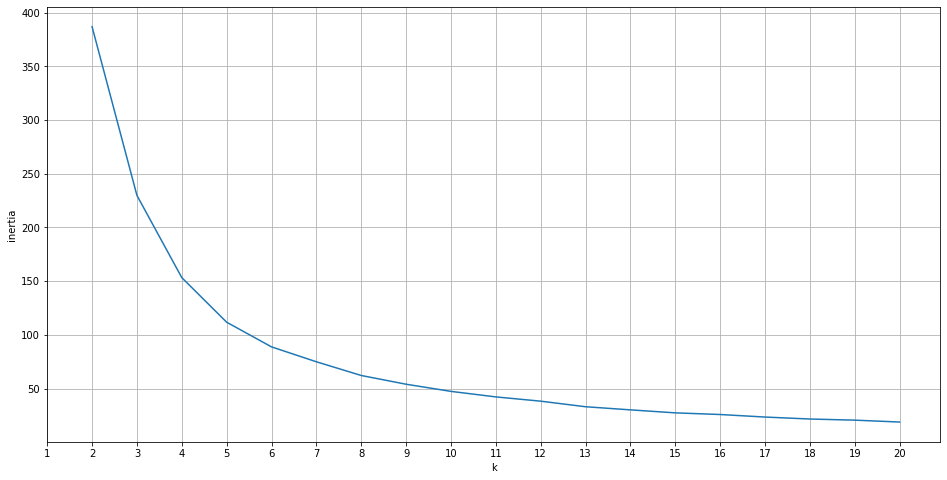

In [42]:
pd.Series({k: ex.get_inertia(k, X) for k in range(2, 21)}).plot()
plt.grid()
plt.xlabel("k")
plt.ylabel("inertia")
plt.xticks(range(1, 21))
plt.show()

## Three Clusters: EI & NC Ratio

In [43]:
kmeans = KMeans(n_clusters=3, random_state=123)
kmeans.fit(X)

model_df["cluster"] = kmeans.predict(X)

In [44]:
centriods = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centriods

,ei,nc_ratio
0,0.23322,1.28086
1,0.78488,-0.63674
2,-0.89978,-0.72863


In [45]:
model_df.groupby("cluster")["ei", "nc_ratio"].mean()

,ei,nc_ratio
cluster,,
0,0.23322,1.28086
1,0.78488,-0.63674
2,-0.89978,-0.72863


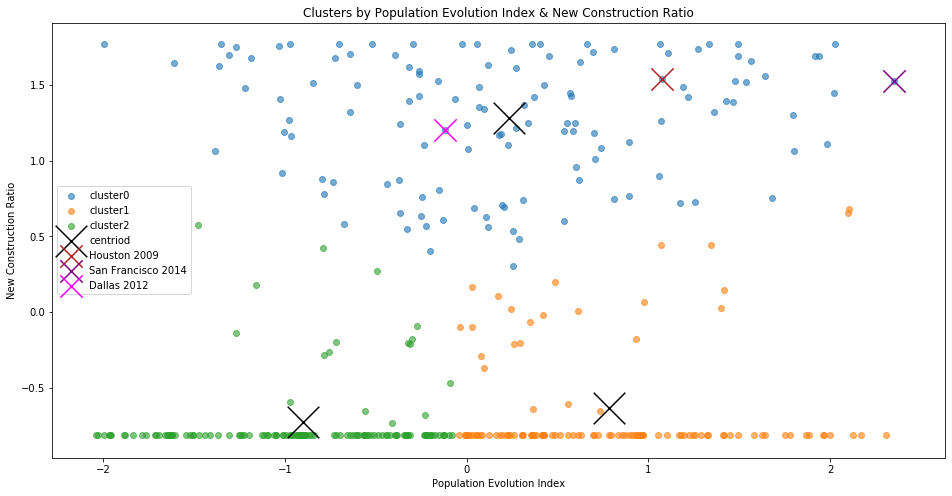

In [46]:
for cluster, subset in model_df.groupby("cluster"):
    plt.scatter(
        subset.ei, subset.nc_ratio, label="cluster" + str(cluster), alpha=0.6
    )

centriods.plot.scatter(
    x="ei",
    y="nc_ratio",
    c="black",
    marker="x",
    s=1000,
    ax=plt.gca(),
    label="centriod",
)

houston_2009 = model_df[(model_df.city == "Houston") & (model_df.state == "TX") & (model_df.year == 2009)]

houston_2009.plot.scatter(
    x="ei",
    y="nc_ratio",
    c="firebrick",
    marker="x",
    s=500,
    ax=plt.gca(),
    label="Houston 2009",
)

# seattle not in dataset
# seattle_2010 = model_df[(model_df.city == "Seattle") & (model_df.state == "WA") & (model_df.year == 2010)]

# seattle_2010.plot.scatter(
#     x="ei",
#     y="nc_ratio",
#     c="purple",
#     marker="x",
#     s=2000,
#     ax=plt.gca(),
#     label="Seattle 2010",
# )

df_2014 = model_df[(model_df.city == "San Francisco") & (model_df.state == "CA") & (model_df.year == 2014)]

df_2014.plot.scatter(
    x="ei",
    y="nc_ratio",
    c="purple",
    marker="x",
    s=500,
    ax=plt.gca(),
    label="San Francisco 2014",
)

dallas_2012 = model_df[(model_df.city == "Dallas") & (model_df.state == "TX")  & (model_df.year == 2012)]

dallas_2012.plot.scatter(
    x="ei",
    y="nc_ratio",
    c="magenta",
    marker="x",
    s=500,
    ax=plt.gca(),
    label="Dallas 2012",
)

plt.legend()
plt.title("Clusters by Population Evolution Index & New Construction Ratio")
plt.xlabel("Population Evolution Index")
plt.ylabel("New Construction Ratio")
plt.show()

In [47]:
model_df.cluster.value_counts()

2    128
0    127
1    109
Name: cluster, dtype: int64

In [48]:
model_df

,city,state,year,quantity_of_mortgages_pop,total_mortgage_volume_pop,average_mortgage_volume_pop,median_mortgage_amount_pop,quantity_of_mortgages_nc,total_mortgage_volume_nc,average_mortgage_volume_nc,median_mortgage_amount_nc,label,city_state_vol_delta_pop,city_state_vol_delta_nc,city_state_qty_delta_pop,city_state_qty_delta_nc,market_volume,market_volume_delta,ei,city_state,nc_ratio,ei_zscore_pop,cluster
1,Atlanta,GA,2007,8,28277600,3534700.00000,3031150.00000,2.00000,4541700.00000,2270850.00000,2270850.00000,False,-0.14793,-0.50532,0.33333,0.00000,4973263164,-0.26584,0.10651,Atlanta_GA,0.62950,-0.24362,0
2,Atlanta,GA,2008,2,6735000,3367500.00000,3367500.00000,1.00000,4950000.00000,4950000.00000,4950000.00000,False,-0.76183,0.08990,-0.75000,-0.50000,4444102426,-0.10640,-1.30611,Atlanta_GA,1.69619,-0.51135,0
3,Atlanta,GA,2009,9,49972900,5552544.44444,4400000.00000,1.00000,3750000.00000,3750000.00000,3750000.00000,False,6.41988,-0.24242,3.50000,0.00000,7882704846,0.77375,1.39756,Atlanta_GA,0.02839,0.66148,1
4,Atlanta,GA,2010,11,68788385,6253489.54545,5196100.00000,2.00000,7203500.00000,3601750.00000,3601750.00000,False,0.37651,0.92093,0.22222,1.00000,16193901958,1.05436,-0.49526,Atlanta_GA,0.27029,-0.39052,2
5,Atlanta,GA,2011,10,56215900,5621590.00000,4341850.00000,2.00000,9274500.00000,4637250.00000,4637250.00000,False,-0.18277,0.28750,-0.09091,0.00000,17502078323,0.08078,-0.36724,Atlanta_GA,0.65322,-0.36474,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,Washington,DC,2016,8,312836100,39104512.50000,27352400.00000,2.00000,54704800.00000,27352400.00000,27352400.00000,False,0.44589,2.40212,0.00000,0.00000,15620858461,0.15114,0.19522,Washington_DC,0.70489,-0.21504,0
386,Washington,DC,2017,8,137557300,17194662.50000,11693000.00000,1.00000,12735000.00000,12735000.00000,12735000.00000,False,-0.56029,-0.76721,0.00000,-0.50000,21015474899,0.34535,-1.15609,Washington_DC,0.17629,-0.49329,2
387,Washington,DC,2018,7,169249000,24178428.57143,25450000.00000,3.00000,46635000.00000,15545000.00000,15235000.00000,False,0.23039,2.66196,-0.12500,2.00000,19982398757,-0.04916,0.22860,Washington_DC,1.10406,-0.20368,0
388,Washington,DC,2019,5,61723450,12344690.00000,9300000.00000,1.00000,18333450.00000,18333450.00000,18333450.00000,False,-0.63531,-0.60687,-0.28571,-0.66667,17749190888,-0.11176,-0.96751,Washington_DC,1.16614,-0.46822,0


---
## Four Clusters: EI & NC Ratio

In [49]:
kmeans = KMeans(n_clusters=5, random_state=123)
kmeans.fit(X)

model_df["cluster"] = kmeans.predict(X)

In [50]:
centriods = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centriods

,ei,nc_ratio
0,1.25409,-0.74415
1,-1.26398,-0.76337
2,-0.41978,1.19992
3,1.14246,1.30961
4,-0.03492,-0.67205


In [51]:
model_df.groupby("cluster")["ei", "nc_ratio"].mean()

,ei,nc_ratio
cluster,,
0,1.25409,-0.74415
1,-1.26398,-0.76337
2,-0.41978,1.19992
3,1.14246,1.30961
4,-0.03492,-0.67205


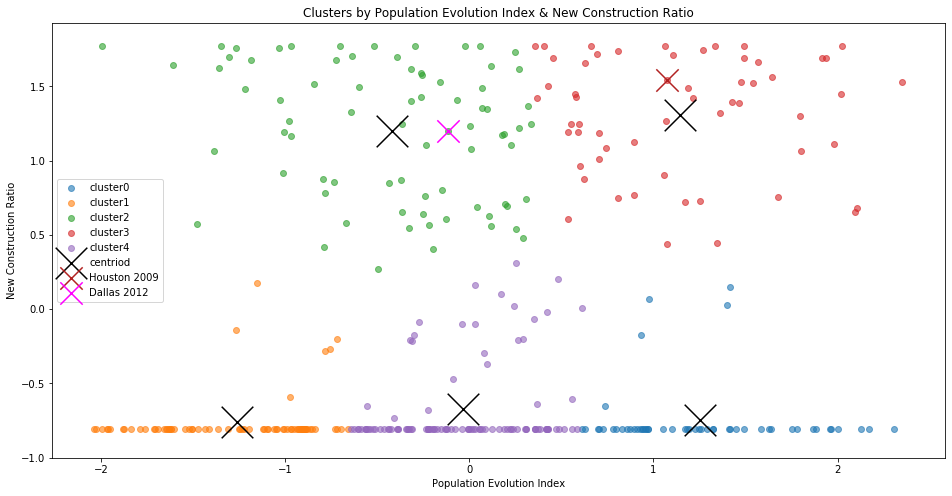

In [52]:
for cluster, subset in model_df.groupby("cluster"):
    plt.scatter(
        subset.ei, subset.nc_ratio, label="cluster" + str(cluster), alpha=0.6
    )

centriods.plot.scatter(
    x="ei",
    y="nc_ratio",
    c="black",
    marker="x",
    s=1000,
    ax=plt.gca(),
    label="centriod",
)

houston_2009 = model_df[(model_df.city == "Houston") & (model_df.state == "TX") & (model_df.year == 2009)]

houston_2009.plot.scatter(
    x="ei",
    y="nc_ratio",
    c="firebrick",
    marker="x",
    s=500,
    ax=plt.gca(),
    label="Houston 2009",
)

dallas_2012 = model_df[(model_df.city == "Dallas") & (model_df.state == "TX")  & (model_df.year == 2012)]

dallas_2012.plot.scatter(
    x="ei",
    y="nc_ratio",
    c="magenta",
    marker="x",
    s=500,
    ax=plt.gca(),
    label="Dallas 2012",
)

plt.legend()
plt.title("Clusters by Population Evolution Index & New Construction Ratio")
plt.xlabel("Population Evolution Index")
plt.ylabel("New Construction Ratio")
plt.show()

In [53]:
model_df.cluster.value_counts()

4    104
2     76
1     75
3     57
0     52
Name: cluster, dtype: int64

---
## Using Z-Score of EI & NC Ratio

In [54]:
model_df

,city,state,year,quantity_of_mortgages_pop,total_mortgage_volume_pop,average_mortgage_volume_pop,median_mortgage_amount_pop,quantity_of_mortgages_nc,total_mortgage_volume_nc,average_mortgage_volume_nc,median_mortgage_amount_nc,label,city_state_vol_delta_pop,city_state_vol_delta_nc,city_state_qty_delta_pop,city_state_qty_delta_nc,market_volume,market_volume_delta,ei,city_state,nc_ratio,ei_zscore_pop,cluster
1,Atlanta,GA,2007,8,28277600,3534700.00000,3031150.00000,2.00000,4541700.00000,2270850.00000,2270850.00000,False,-0.14793,-0.50532,0.33333,0.00000,4973263164,-0.26584,0.10651,Atlanta_GA,0.62950,-0.24362,2
2,Atlanta,GA,2008,2,6735000,3367500.00000,3367500.00000,1.00000,4950000.00000,4950000.00000,4950000.00000,False,-0.76183,0.08990,-0.75000,-0.50000,4444102426,-0.10640,-1.30611,Atlanta_GA,1.69619,-0.51135,2
3,Atlanta,GA,2009,9,49972900,5552544.44444,4400000.00000,1.00000,3750000.00000,3750000.00000,3750000.00000,False,6.41988,-0.24242,3.50000,0.00000,7882704846,0.77375,1.39756,Atlanta_GA,0.02839,0.66148,0
4,Atlanta,GA,2010,11,68788385,6253489.54545,5196100.00000,2.00000,7203500.00000,3601750.00000,3601750.00000,False,0.37651,0.92093,0.22222,1.00000,16193901958,1.05436,-0.49526,Atlanta_GA,0.27029,-0.39052,2
5,Atlanta,GA,2011,10,56215900,5621590.00000,4341850.00000,2.00000,9274500.00000,4637250.00000,4637250.00000,False,-0.18277,0.28750,-0.09091,0.00000,17502078323,0.08078,-0.36724,Atlanta_GA,0.65322,-0.36474,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,Washington,DC,2016,8,312836100,39104512.50000,27352400.00000,2.00000,54704800.00000,27352400.00000,27352400.00000,False,0.44589,2.40212,0.00000,0.00000,15620858461,0.15114,0.19522,Washington_DC,0.70489,-0.21504,2
386,Washington,DC,2017,8,137557300,17194662.50000,11693000.00000,1.00000,12735000.00000,12735000.00000,12735000.00000,False,-0.56029,-0.76721,0.00000,-0.50000,21015474899,0.34535,-1.15609,Washington_DC,0.17629,-0.49329,1
387,Washington,DC,2018,7,169249000,24178428.57143,25450000.00000,3.00000,46635000.00000,15545000.00000,15235000.00000,False,0.23039,2.66196,-0.12500,2.00000,19982398757,-0.04916,0.22860,Washington_DC,1.10406,-0.20368,2
388,Washington,DC,2019,5,61723450,12344690.00000,9300000.00000,1.00000,18333450.00000,18333450.00000,18333450.00000,False,-0.63531,-0.60687,-0.28571,-0.66667,17749190888,-0.11176,-0.96751,Washington_DC,1.16614,-0.46822,2


In [55]:
model_df[["ei", "nc_ratio"]] = scaler.inverse_transform(model_df[["ei", "nc_ratio"]])
model_df

,city,state,year,quantity_of_mortgages_pop,total_mortgage_volume_pop,average_mortgage_volume_pop,median_mortgage_amount_pop,quantity_of_mortgages_nc,total_mortgage_volume_nc,average_mortgage_volume_nc,median_mortgage_amount_nc,label,city_state_vol_delta_pop,city_state_vol_delta_nc,city_state_qty_delta_pop,city_state_qty_delta_nc,market_volume,market_volume_delta,ei,city_state,nc_ratio,ei_zscore_pop,cluster
1,Atlanta,GA,2007,8,28277600,3534700.00000,3031150.00000,2.00000,4541700.00000,2270850.00000,2270850.00000,False,-0.14793,-0.50532,0.33333,0.00000,4973263164,-0.26584,1.16062,Atlanta_GA,0.16061,-0.24362,2
2,Atlanta,GA,2008,2,6735000,3367500.00000,3367500.00000,1.00000,4950000.00000,4950000.00000,4950000.00000,False,-0.76183,0.08990,-0.75000,-0.50000,4444102426,-0.10640,0.26653,Atlanta_GA,0.73497,-0.51135,2
3,Atlanta,GA,2009,9,49972900,5552544.44444,4400000.00000,1.00000,3750000.00000,3750000.00000,3750000.00000,False,6.41988,-0.24242,3.50000,0.00000,7882704846,0.77375,4.18317,Atlanta_GA,0.07504,0.66148,0
4,Atlanta,GA,2010,11,68788385,6253489.54545,5196100.00000,2.00000,7203500.00000,3601750.00000,3601750.00000,False,0.37651,0.92093,0.22222,1.00000,16193901958,1.05436,0.67005,Atlanta_GA,0.10472,-0.39052,2
5,Atlanta,GA,2011,10,56215900,5621590.00000,4341850.00000,2.00000,9274500.00000,4637250.00000,4637250.00000,False,-0.18277,0.28750,-0.09091,0.00000,17502078323,0.08078,0.75615,Atlanta_GA,0.16498,-0.36474,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,Washington,DC,2016,8,312836100,39104512.50000,27352400.00000,2.00000,54704800.00000,27352400.00000,27352400.00000,False,0.44589,2.40212,0.00000,0.00000,15620858461,0.15114,1.25605,Washington_DC,0.17487,-0.21504,2
386,Washington,DC,2017,8,137557300,17194662.50000,11693000.00000,1.00000,12735000.00000,12735000.00000,12735000.00000,False,-0.56029,-0.76721,0.00000,-0.50000,21015474899,0.34535,0.32684,Washington_DC,0.09258,-0.49329,1
387,Washington,DC,2018,7,169249000,24178428.57143,25450000.00000,3.00000,46635000.00000,15545000.00000,15235000.00000,False,0.23039,2.66196,-0.12500,2.00000,19982398757,-0.04916,1.29400,Washington_DC,0.27554,-0.20368,2
388,Washington,DC,2019,5,61723450,12344690.00000,9300000.00000,1.00000,18333450.00000,18333450.00000,18333450.00000,False,-0.63531,-0.60687,-0.28571,-0.66667,17749190888,-0.11176,0.41058,Washington_DC,0.29703,-0.46822,2


In [56]:
X = model_df[["ei_zscore_pop", "nc_ratio"]]

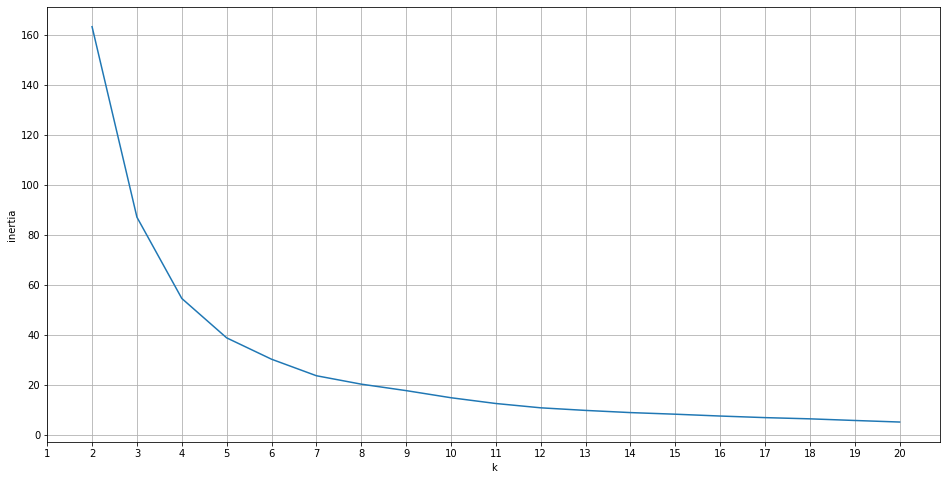

In [57]:
pd.Series({k: ex.get_inertia(k, X) for k in range(2, 21)}).plot()
plt.grid()
plt.xlabel("k")
plt.ylabel("inertia")
plt.xticks(range(1, 21))
plt.show()

## Five Clusters: EI Z-Score & NC Ratio

In [58]:
kmeans = KMeans(n_clusters=5, random_state=123)
kmeans.fit(X)

model_df["cluster"] = kmeans.predict(X)

In [59]:
centriods = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centriods

,ei_zscore_pop,nc_ratio
0,0.70676,0.23283
1,9.14163,0.25108
2,2.89881,0.24941
3,-0.30259,0.05492
4,-0.28146,0.69091


In [60]:
model_df.groupby("cluster")["ei_zscore_pop", "nc_ratio"].mean()

,ei_zscore_pop,nc_ratio
cluster,,
0,0.70676,0.23283
1,9.14163,0.25108
2,2.89881,0.24941
3,-0.30259,0.05492
4,-0.28146,0.69091


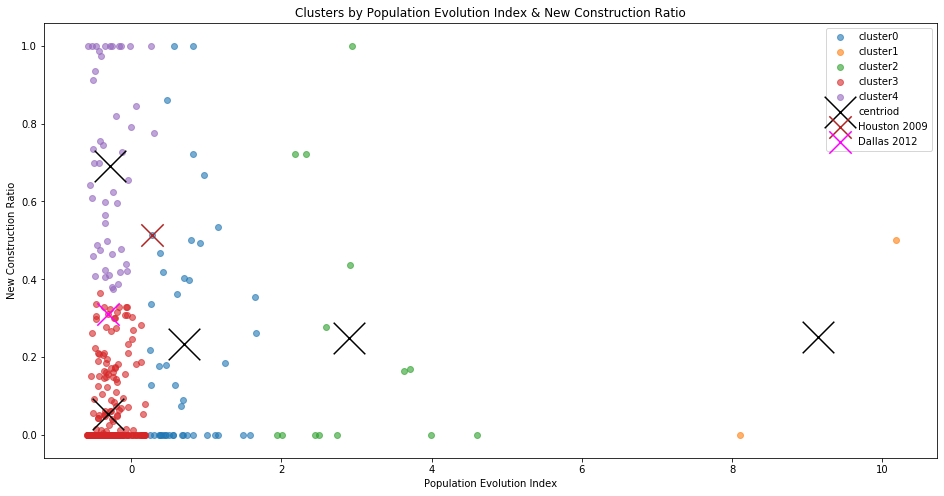

In [61]:
for cluster, subset in model_df.groupby("cluster"):
    plt.scatter(
        subset.ei_zscore_pop, subset.nc_ratio, label="cluster" + str(cluster), alpha=0.6
    )

centriods.plot.scatter(
    x="ei_zscore_pop",
    y="nc_ratio",
    c="black",
    marker="x",
    s=1000,
    ax=plt.gca(),
    label="centriod",
)

houston_2009 = model_df[(model_df.city == "Houston") & (model_df.state == "TX") & (model_df.year == 2009)]

houston_2009.plot.scatter(
    x="ei_zscore_pop",
    y="nc_ratio",
    c="firebrick",
    marker="x",
    s=500,
    ax=plt.gca(),
    label="Houston 2009",
)

dallas_2012 = model_df[(model_df.city == "Dallas") & (model_df.state == "TX")  & (model_df.year == 2012)]

dallas_2012.plot.scatter(
    x="ei_zscore_pop",
    y="nc_ratio",
    c="magenta",
    marker="x",
    s=500,
    ax=plt.gca(),
    label="Dallas 2012",
)

plt.legend()
plt.title("Clusters by Population Evolution Index & New Construction Ratio")
plt.xlabel("Population Evolution Index")
plt.ylabel("New Construction Ratio")
plt.show()

---
### Standup 2020-06-23

**Ryan**:

Elevator Pitch:

“What’s your project about” is super valuable to have ready. Your project elevator pitch is right up there w/ “Tell me about yourself” and “What is Data Science” and “What brought you to data science”

In [62]:
model_df

,city,state,year,quantity_of_mortgages_pop,total_mortgage_volume_pop,average_mortgage_volume_pop,median_mortgage_amount_pop,quantity_of_mortgages_nc,total_mortgage_volume_nc,average_mortgage_volume_nc,median_mortgage_amount_nc,label,city_state_vol_delta_pop,city_state_vol_delta_nc,city_state_qty_delta_pop,city_state_qty_delta_nc,market_volume,market_volume_delta,ei,city_state,nc_ratio,ei_zscore_pop,cluster
1,Atlanta,GA,2007,8,28277600,3534700.00000,3031150.00000,2.00000,4541700.00000,2270850.00000,2270850.00000,False,-0.14793,-0.50532,0.33333,0.00000,4973263164,-0.26584,1.16062,Atlanta_GA,0.16061,-0.24362,3
2,Atlanta,GA,2008,2,6735000,3367500.00000,3367500.00000,1.00000,4950000.00000,4950000.00000,4950000.00000,False,-0.76183,0.08990,-0.75000,-0.50000,4444102426,-0.10640,0.26653,Atlanta_GA,0.73497,-0.51135,4
3,Atlanta,GA,2009,9,49972900,5552544.44444,4400000.00000,1.00000,3750000.00000,3750000.00000,3750000.00000,False,6.41988,-0.24242,3.50000,0.00000,7882704846,0.77375,4.18317,Atlanta_GA,0.07504,0.66148,0
4,Atlanta,GA,2010,11,68788385,6253489.54545,5196100.00000,2.00000,7203500.00000,3601750.00000,3601750.00000,False,0.37651,0.92093,0.22222,1.00000,16193901958,1.05436,0.67005,Atlanta_GA,0.10472,-0.39052,3
5,Atlanta,GA,2011,10,56215900,5621590.00000,4341850.00000,2.00000,9274500.00000,4637250.00000,4637250.00000,False,-0.18277,0.28750,-0.09091,0.00000,17502078323,0.08078,0.75615,Atlanta_GA,0.16498,-0.36474,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,Washington,DC,2016,8,312836100,39104512.50000,27352400.00000,2.00000,54704800.00000,27352400.00000,27352400.00000,False,0.44589,2.40212,0.00000,0.00000,15620858461,0.15114,1.25605,Washington_DC,0.17487,-0.21504,3
386,Washington,DC,2017,8,137557300,17194662.50000,11693000.00000,1.00000,12735000.00000,12735000.00000,12735000.00000,False,-0.56029,-0.76721,0.00000,-0.50000,21015474899,0.34535,0.32684,Washington_DC,0.09258,-0.49329,3
387,Washington,DC,2018,7,169249000,24178428.57143,25450000.00000,3.00000,46635000.00000,15545000.00000,15235000.00000,False,0.23039,2.66196,-0.12500,2.00000,19982398757,-0.04916,1.29400,Washington_DC,0.27554,-0.20368,3
388,Washington,DC,2019,5,61723450,12344690.00000,9300000.00000,1.00000,18333450.00000,18333450.00000,18333450.00000,False,-0.63531,-0.60687,-0.28571,-0.66667,17749190888,-0.11176,0.41058,Washington_DC,0.29703,-0.46822,3


In [63]:
scaler = MinMaxScaler()
scaler.fit(model_df[["ei", "median_mortgage_amount_pop"]])
model_df[["ei", "median_mortgage_amount_pop"]] = scaler.transform(model_df[["ei", "median_mortgage_amount_pop"]])

In [64]:
X = model_df[["ei", "median_mortgage_amount_pop"]]

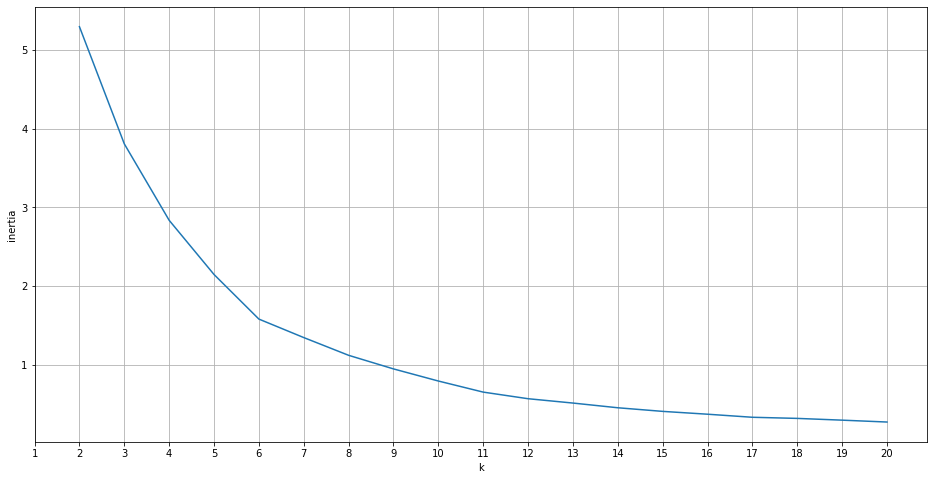

In [65]:
pd.Series({k: ex.get_inertia(k, X) for k in range(2, 21)}).plot()
plt.grid()
plt.xlabel("k")
plt.ylabel("inertia")
plt.xticks(range(1, 21))
plt.show()

## Four Clusters: EI & Median Mortgage Amount

In [66]:
kmeans = KMeans(n_clusters=4, random_state=123)
kmeans.fit(X)

model_df["cluster"] = kmeans.predict(X)

In [67]:
centriods = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centriods

,ei,median_mortgage_amount_pop
0,0.03268,0.07123
1,0.05796,0.52917
2,0.43079,0.25410
3,0.05211,0.20058


In [68]:
model_df.groupby("cluster")["ei", "median_mortgage_amount_pop"].mean()

,ei,median_mortgage_amount_pop
cluster,,
0,0.03268,0.07123
1,0.05796,0.52917
2,0.43079,0.25410
3,0.05211,0.20058


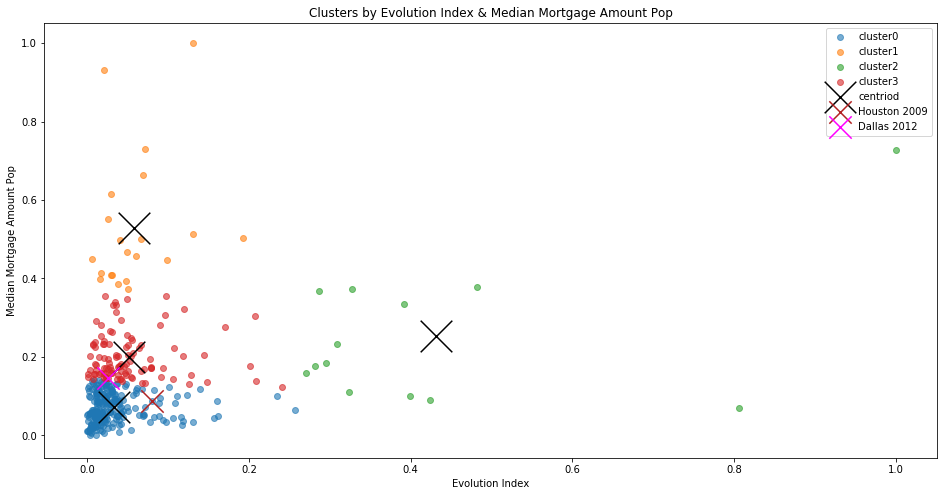

In [69]:
for cluster, subset in model_df.groupby("cluster"):
    plt.scatter(
        subset.ei, subset.median_mortgage_amount_pop, label="cluster" + str(cluster), alpha=0.6
    )

centriods.plot.scatter(
    x="ei",
    y="median_mortgage_amount_pop",
    c="black",
    marker="x",
    s=1000,
    ax=plt.gca(),
    label="centriod",
)

houston_2009 = model_df[(model_df.city == "Houston") & (model_df.state == "TX") & (model_df.year == 2009)]

houston_2009.plot.scatter(
    x="ei",
    y="median_mortgage_amount_pop",
    c="firebrick",
    marker="x",
    s=500,
    ax=plt.gca(),
    label="Houston 2009",
)

dallas_2012 = model_df[(model_df.city == "Dallas") & (model_df.state == "TX")  & (model_df.year == 2012)]

dallas_2012.plot.scatter(
    x="ei",
    y="median_mortgage_amount_pop",
    c="magenta",
    marker="x",
    s=500,
    ax=plt.gca(),
    label="Dallas 2012",
)

plt.legend()
plt.title("Clusters by Evolution Index & Median Mortgage Amount Pop")
plt.xlabel("Evolution Index")
plt.ylabel("Median Mortgage Amount Pop")
plt.show()

In [70]:
model_df

,city,state,year,quantity_of_mortgages_pop,total_mortgage_volume_pop,average_mortgage_volume_pop,median_mortgage_amount_pop,quantity_of_mortgages_nc,total_mortgage_volume_nc,average_mortgage_volume_nc,median_mortgage_amount_nc,label,city_state_vol_delta_pop,city_state_vol_delta_nc,city_state_qty_delta_pop,city_state_qty_delta_nc,market_volume,market_volume_delta,ei,city_state,nc_ratio,ei_zscore_pop,cluster
1,Atlanta,GA,2007,8,28277600,3534700.00000,0.03021,2.00000,4541700.00000,2270850.00000,2270850.00000,False,-0.14793,-0.50532,0.33333,0.00000,4973263164,-0.26584,0.03138,Atlanta_GA,0.16061,-0.24362,0
2,Atlanta,GA,2008,2,6735000,3367500.00000,0.03449,1.00000,4950000.00000,4950000.00000,4950000.00000,False,-0.76183,0.08990,-0.75000,-0.50000,4444102426,-0.10640,0.00650,Atlanta_GA,0.73497,-0.51135,0
3,Atlanta,GA,2009,9,49972900,5552544.44444,0.04761,1.00000,3750000.00000,3750000.00000,3750000.00000,False,6.41988,-0.24242,3.50000,0.00000,7882704846,0.77375,0.11547,Atlanta_GA,0.07504,0.66148,0
4,Atlanta,GA,2010,11,68788385,6253489.54545,0.05774,2.00000,7203500.00000,3601750.00000,3601750.00000,False,0.37651,0.92093,0.22222,1.00000,16193901958,1.05436,0.01773,Atlanta_GA,0.10472,-0.39052,0
5,Atlanta,GA,2011,10,56215900,5621590.00000,0.04687,2.00000,9274500.00000,4637250.00000,4637250.00000,False,-0.18277,0.28750,-0.09091,0.00000,17502078323,0.08078,0.02012,Atlanta_GA,0.16498,-0.36474,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,Washington,DC,2016,8,312836100,39104512.50000,0.33943,2.00000,54704800.00000,27352400.00000,27352400.00000,False,0.44589,2.40212,0.00000,0.00000,15620858461,0.15114,0.03403,Washington_DC,0.17487,-0.21504,3
386,Washington,DC,2017,8,137557300,17194662.50000,0.14034,1.00000,12735000.00000,12735000.00000,12735000.00000,False,-0.56029,-0.76721,0.00000,-0.50000,21015474899,0.34535,0.00818,Washington_DC,0.09258,-0.49329,0
387,Washington,DC,2018,7,169249000,24178428.57143,0.31525,3.00000,46635000.00000,15545000.00000,15235000.00000,False,0.23039,2.66196,-0.12500,2.00000,19982398757,-0.04916,0.03509,Washington_DC,0.27554,-0.20368,3
388,Washington,DC,2019,5,61723450,12344690.00000,0.10991,1.00000,18333450.00000,18333450.00000,18333450.00000,False,-0.63531,-0.60687,-0.28571,-0.66667,17749190888,-0.11176,0.01051,Washington_DC,0.29703,-0.46822,0


In [71]:
model_df = labeling_future_data(model_df)

In [72]:
model_df

,city,state,year,quantity_of_mortgages_pop,total_mortgage_volume_pop,average_mortgage_volume_pop,median_mortgage_amount_pop,quantity_of_mortgages_nc,total_mortgage_volume_nc,average_mortgage_volume_nc,median_mortgage_amount_nc,label,city_state_vol_delta_pop,city_state_vol_delta_nc,city_state_qty_delta_pop,city_state_qty_delta_nc,market_volume,market_volume_delta,ei,city_state,nc_ratio,ei_zscore_pop,cluster,label_quantity_of_mortgages_pop_2y,label_total_mortgage_volume_pop_2y,should_enter
1,Atlanta,GA,2007,8,28277600,3534700.00000,0.03021,2.00000,4541700.00000,2270850.00000,2270850.00000,False,-0.14793,-0.50532,0.33333,0.00000,4973263164,-0.26584,0.03138,Atlanta_GA,0.16061,-0.24362,0,nan,nan,False
2,Atlanta,GA,2008,2,6735000,3367500.00000,0.03449,1.00000,4950000.00000,4950000.00000,4950000.00000,False,-0.76183,0.08990,-0.75000,-0.50000,4444102426,-0.10640,0.00650,Atlanta_GA,0.73497,-0.51135,0,nan,nan,False
3,Atlanta,GA,2009,9,49972900,5552544.44444,0.04761,1.00000,3750000.00000,3750000.00000,3750000.00000,False,6.41988,-0.24242,3.50000,0.00000,7882704846,0.77375,0.11547,Atlanta_GA,0.07504,0.66148,0,0.50000,8.99895,True
4,Atlanta,GA,2010,11,68788385,6253489.54545,0.05774,2.00000,7203500.00000,3601750.00000,3601750.00000,False,0.37651,0.92093,0.22222,1.00000,16193901958,1.05436,0.01773,Atlanta_GA,0.10472,-0.39052,0,3.00000,22.17829,True
5,Atlanta,GA,2011,10,56215900,5621590.00000,0.04687,2.00000,9274500.00000,4637250.00000,4637250.00000,False,-0.18277,0.28750,-0.09091,0.00000,17502078323,0.08078,0.02012,Atlanta_GA,0.16498,-0.36474,0,5.00000,2.94255,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,Washington,DC,2016,8,312836100,39104512.50000,0.33943,2.00000,54704800.00000,27352400.00000,27352400.00000,False,0.44589,2.40212,0.00000,0.00000,15620858461,0.15114,0.03403,Washington_DC,0.17487,-0.21504,3,-0.40000,0.32907,False
386,Washington,DC,2017,8,137557300,17194662.50000,0.14034,1.00000,12735000.00000,12735000.00000,12735000.00000,False,-0.56029,-0.76721,0.00000,-0.50000,21015474899,0.34535,0.00818,Washington_DC,0.09258,-0.49329,0,-0.11765,0.70617,False
387,Washington,DC,2018,7,169249000,24178428.57143,0.31525,3.00000,46635000.00000,15545000.00000,15235000.00000,False,0.23039,2.66196,-0.12500,2.00000,19982398757,-0.04916,0.03509,Washington_DC,0.27554,-0.20368,3,0.60000,3.36612,False
388,Washington,DC,2019,5,61723450,12344690.00000,0.10991,1.00000,18333450.00000,18333450.00000,18333450.00000,False,-0.63531,-0.60687,-0.28571,-0.66667,17749190888,-0.11176,0.01051,Washington_DC,0.29703,-0.46822,0,-0.60000,-0.57683,False


In [73]:
model_df[
    ((model_df.city == "Atlanta") & (model_df.state == "GA"))
    | ((model_df.city == "Austin") & (model_df.state == "TX"))
].sort_values(by=["city", "state", "year"])

,city,state,year,quantity_of_mortgages_pop,total_mortgage_volume_pop,average_mortgage_volume_pop,median_mortgage_amount_pop,quantity_of_mortgages_nc,total_mortgage_volume_nc,average_mortgage_volume_nc,median_mortgage_amount_nc,label,city_state_vol_delta_pop,city_state_vol_delta_nc,city_state_qty_delta_pop,city_state_qty_delta_nc,market_volume,market_volume_delta,ei,city_state,nc_ratio,ei_zscore_pop,cluster,label_quantity_of_mortgages_pop_2y,label_total_mortgage_volume_pop_2y,should_enter
1,Atlanta,GA,2007,8,28277600,3534700.00000,0.03021,2.00000,4541700.00000,2270850.00000,2270850.00000,False,-0.14793,-0.50532,0.33333,0.00000,4973263164,-0.26584,0.03138,Atlanta_GA,0.16061,-0.24362,0,nan,nan,False
2,Atlanta,GA,2008,2,6735000,3367500.00000,0.03449,1.00000,4950000.00000,4950000.00000,4950000.00000,False,-0.76183,0.08990,-0.75000,-0.50000,4444102426,-0.10640,0.00650,Atlanta_GA,0.73497,-0.51135,0,nan,nan,False
3,Atlanta,GA,2009,9,49972900,5552544.44444,0.04761,1.00000,3750000.00000,3750000.00000,3750000.00000,False,6.41988,-0.24242,3.50000,0.00000,7882704846,0.77375,0.11547,Atlanta_GA,0.07504,0.66148,0,0.50000,8.99895,True
4,Atlanta,GA,2010,11,68788385,6253489.54545,0.05774,2.00000,7203500.00000,3601750.00000,3601750.00000,False,0.37651,0.92093,0.22222,1.00000,16193901958,1.05436,0.01773,Atlanta_GA,0.10472,-0.39052,0,3.00000,22.17829,True
5,Atlanta,GA,2011,10,56215900,5621590.00000,0.04687,2.00000,9274500.00000,4637250.00000,4637250.00000,False,-0.18277,0.28750,-0.09091,0.00000,17502078323,0.08078,0.02012,Atlanta_GA,0.16498,-0.36474,0,5.00000,2.94255,True
6,Atlanta,GA,2012,12,56365900,4697158.33333,0.03299,1.00000,3000000.00000,3000000.00000,3000000.00000,False,0.00267,-0.67653,0.20000,-0.50000,21797876931,0.24545,0.02148,Atlanta_GA,0.05322,-0.35009,0,0.00000,0.55928,False
7,Atlanta,GA,2013,19,138582800,7293831.57895,0.06966,nan,nan,nan,nan,False,1.45863,0.00000,0.58333,0.00000,24940177380,0.14416,0.05887,Atlanta_GA,0.00000,0.05231,0,0.30000,0.73344,False
8,Atlanta,GA,2014,11,106803300,9709390.90909,0.05422,1.00000,15861400.00000,15861400.00000,15861400.00000,False,-0.22932,4.28713,-0.42105,0.00000,16405588955,-0.34220,0.03168,Atlanta_GA,0.14851,-0.24033,0,-0.20000,-0.58162,False
9,Atlanta,GA,2015,4,20900000,5225000.00000,0.06478,1.00000,5500000.00000,5500000.00000,5500000.00000,False,-0.80431,-0.65325,-0.63636,0.00000,13569931547,-0.17285,0.00567,Atlanta_GA,0.26316,-0.52032,0,-0.40000,-0.51355,False
10,Atlanta,GA,2016,4,27639900,6909975.00000,0.08512,1.00000,10350000.00000,10350000.00000,10350000.00000,False,0.32248,0.88182,0.00000,0.00000,15620858461,0.15114,0.03105,Atlanta_GA,0.37446,-0.24714,0,1.66667,1.15266,False


In [74]:
(9 - 2) / 2

3.5

In [75]:
model_df

,city,state,year,quantity_of_mortgages_pop,total_mortgage_volume_pop,average_mortgage_volume_pop,median_mortgage_amount_pop,quantity_of_mortgages_nc,total_mortgage_volume_nc,average_mortgage_volume_nc,median_mortgage_amount_nc,label,city_state_vol_delta_pop,city_state_vol_delta_nc,city_state_qty_delta_pop,city_state_qty_delta_nc,market_volume,market_volume_delta,ei,city_state,nc_ratio,ei_zscore_pop,cluster,label_quantity_of_mortgages_pop_2y,label_total_mortgage_volume_pop_2y,should_enter
1,Atlanta,GA,2007,8,28277600,3534700.00000,0.03021,2.00000,4541700.00000,2270850.00000,2270850.00000,False,-0.14793,-0.50532,0.33333,0.00000,4973263164,-0.26584,0.03138,Atlanta_GA,0.16061,-0.24362,0,nan,nan,False
2,Atlanta,GA,2008,2,6735000,3367500.00000,0.03449,1.00000,4950000.00000,4950000.00000,4950000.00000,False,-0.76183,0.08990,-0.75000,-0.50000,4444102426,-0.10640,0.00650,Atlanta_GA,0.73497,-0.51135,0,nan,nan,False
3,Atlanta,GA,2009,9,49972900,5552544.44444,0.04761,1.00000,3750000.00000,3750000.00000,3750000.00000,False,6.41988,-0.24242,3.50000,0.00000,7882704846,0.77375,0.11547,Atlanta_GA,0.07504,0.66148,0,0.50000,8.99895,True
4,Atlanta,GA,2010,11,68788385,6253489.54545,0.05774,2.00000,7203500.00000,3601750.00000,3601750.00000,False,0.37651,0.92093,0.22222,1.00000,16193901958,1.05436,0.01773,Atlanta_GA,0.10472,-0.39052,0,3.00000,22.17829,True
5,Atlanta,GA,2011,10,56215900,5621590.00000,0.04687,2.00000,9274500.00000,4637250.00000,4637250.00000,False,-0.18277,0.28750,-0.09091,0.00000,17502078323,0.08078,0.02012,Atlanta_GA,0.16498,-0.36474,0,5.00000,2.94255,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,Washington,DC,2016,8,312836100,39104512.50000,0.33943,2.00000,54704800.00000,27352400.00000,27352400.00000,False,0.44589,2.40212,0.00000,0.00000,15620858461,0.15114,0.03403,Washington_DC,0.17487,-0.21504,3,-0.40000,0.32907,False
386,Washington,DC,2017,8,137557300,17194662.50000,0.14034,1.00000,12735000.00000,12735000.00000,12735000.00000,False,-0.56029,-0.76721,0.00000,-0.50000,21015474899,0.34535,0.00818,Washington_DC,0.09258,-0.49329,0,-0.11765,0.70617,False
387,Washington,DC,2018,7,169249000,24178428.57143,0.31525,3.00000,46635000.00000,15545000.00000,15235000.00000,False,0.23039,2.66196,-0.12500,2.00000,19982398757,-0.04916,0.03509,Washington_DC,0.27554,-0.20368,3,0.60000,3.36612,False
388,Washington,DC,2019,5,61723450,12344690.00000,0.10991,1.00000,18333450.00000,18333450.00000,18333450.00000,False,-0.63531,-0.60687,-0.28571,-0.66667,17749190888,-0.11176,0.01051,Washington_DC,0.29703,-0.46822,0,-0.60000,-0.57683,False


In [76]:
model_df[["ei", "median_mortgage_amount_pop"]] = scaler.inverse_transform(model_df[["ei", "median_mortgage_amount_pop"]])

In [77]:
# scaler = MinMaxScaler()
# scaler.fit(model_df[["ei", "city_state_vol_delta_pop"]])
# model_df[["ei", "city_state_vol_delta_pop"]] = scaler.transform(model_df[["ei", "city_state_vol_delta_pop"]])

In [78]:
X = model_df[["ei", "city_state_vol_delta_pop"]]

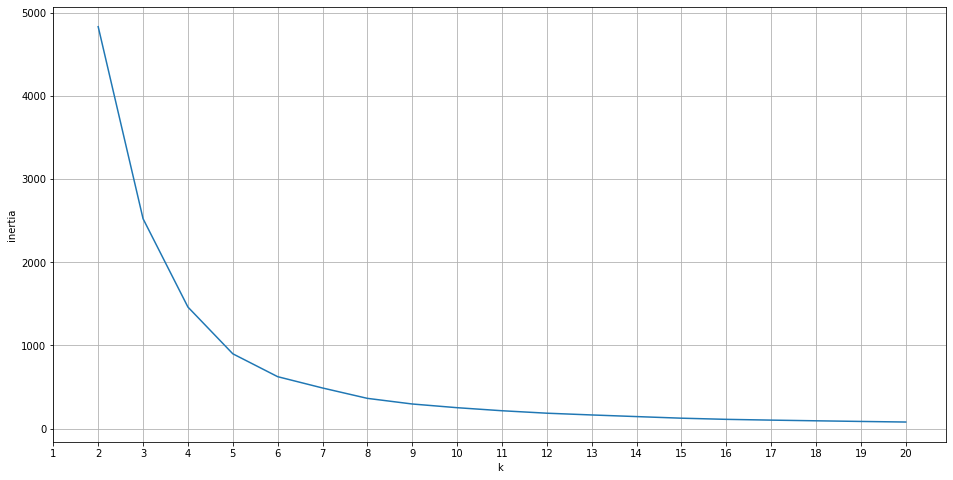

In [79]:
pd.Series({k: ex.get_inertia(k, X) for k in range(2, 21)}).plot()
plt.grid()
plt.xlabel("k")
plt.ylabel("inertia")
plt.xticks(range(1, 21))
plt.show()

## Three Clusters: EI & Median Mortgage Amount

In [80]:
kmeans = KMeans(n_clusters=5, random_state=123)
kmeans.fit(X)

model_df["cluster"] = kmeans.predict(X)

In [81]:
centriods = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centriods

,ei,city_state_vol_delta_pop
0,4.66540,4.57220
1,35.97452,22.66395
2,12.53108,14.35996
3,0.98904,0.01202
4,29.03064,58.63935


In [82]:
model_df.groupby("cluster")["ei", "city_state_vol_delta_pop"].mean()

,ei,city_state_vol_delta_pop
cluster,,
0,4.66540,4.57220
1,35.97452,22.66395
2,12.53108,14.35996
3,0.98904,0.01202
4,29.03064,58.63935


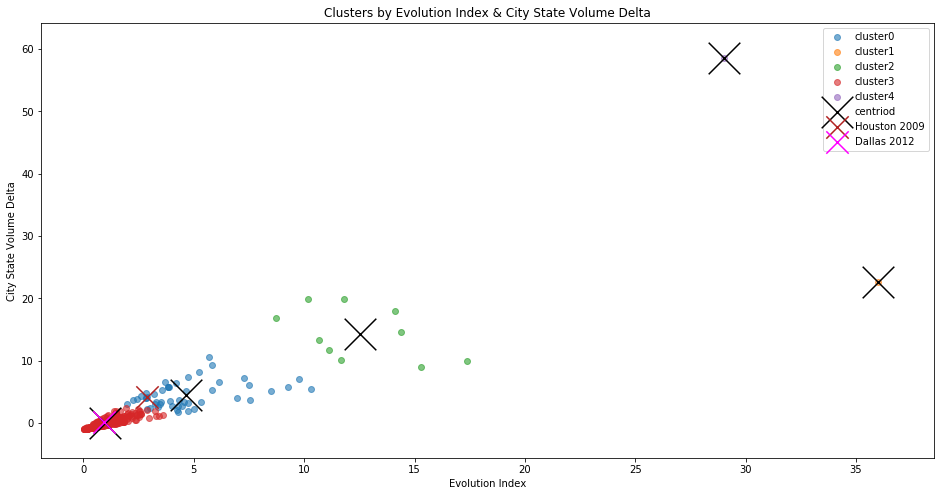

In [83]:
for cluster, subset in model_df.groupby("cluster"):
    plt.scatter(
        subset.ei, subset.city_state_vol_delta_pop, label="cluster" + str(cluster), alpha=0.6
    )

centriods.plot.scatter(
    x="ei",
    y="city_state_vol_delta_pop",
    c="black",
    marker="x",
    s=1000,
    ax=plt.gca(),
    label="centriod",
)

houston_2009 = model_df[(model_df.city == "Houston") & (model_df.state == "TX") & (model_df.year == 2009)]

houston_2009.plot.scatter(
    x="ei",
    y="city_state_vol_delta_pop",
    c="firebrick",
    marker="x",
    s=500,
    ax=plt.gca(),
    label="Houston 2009",
)

dallas_2012 = model_df[(model_df.city == "Dallas") & (model_df.state == "TX")  & (model_df.year == 2012)]

dallas_2012.plot.scatter(
    x="ei",
    y="city_state_vol_delta_pop",
    c="magenta",
    marker="x",
    s=500,
    ax=plt.gca(),
    label="Dallas 2012",
)

plt.legend()
plt.title("Clusters by Evolution Index & City State Volume Delta")
plt.xlabel("Evolution Index")
plt.ylabel("City State Volume Delta")
plt.show()

## Clustering with EI & Total Mortgage Volume

In [84]:
model_df

,city,state,year,quantity_of_mortgages_pop,total_mortgage_volume_pop,average_mortgage_volume_pop,median_mortgage_amount_pop,quantity_of_mortgages_nc,total_mortgage_volume_nc,average_mortgage_volume_nc,median_mortgage_amount_nc,label,city_state_vol_delta_pop,city_state_vol_delta_nc,city_state_qty_delta_pop,city_state_qty_delta_nc,market_volume,market_volume_delta,ei,city_state,nc_ratio,ei_zscore_pop,cluster,label_quantity_of_mortgages_pop_2y,label_total_mortgage_volume_pop_2y,should_enter
1,Atlanta,GA,2007,8,28277600,3534700.00000,3031150.00000,2.00000,4541700.00000,2270850.00000,2270850.00000,False,-0.14793,-0.50532,0.33333,0.00000,4973263164,-0.26584,1.16062,Atlanta_GA,0.16061,-0.24362,3,nan,nan,False
2,Atlanta,GA,2008,2,6735000,3367500.00000,3367500.00000,1.00000,4950000.00000,4950000.00000,4950000.00000,False,-0.76183,0.08990,-0.75000,-0.50000,4444102426,-0.10640,0.26653,Atlanta_GA,0.73497,-0.51135,3,nan,nan,False
3,Atlanta,GA,2009,9,49972900,5552544.44444,4400000.00000,1.00000,3750000.00000,3750000.00000,3750000.00000,False,6.41988,-0.24242,3.50000,0.00000,7882704846,0.77375,4.18317,Atlanta_GA,0.07504,0.66148,0,0.50000,8.99895,True
4,Atlanta,GA,2010,11,68788385,6253489.54545,5196100.00000,2.00000,7203500.00000,3601750.00000,3601750.00000,False,0.37651,0.92093,0.22222,1.00000,16193901958,1.05436,0.67005,Atlanta_GA,0.10472,-0.39052,3,3.00000,22.17829,True
5,Atlanta,GA,2011,10,56215900,5621590.00000,4341850.00000,2.00000,9274500.00000,4637250.00000,4637250.00000,False,-0.18277,0.28750,-0.09091,0.00000,17502078323,0.08078,0.75615,Atlanta_GA,0.16498,-0.36474,3,5.00000,2.94255,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,Washington,DC,2016,8,312836100,39104512.50000,27352400.00000,2.00000,54704800.00000,27352400.00000,27352400.00000,False,0.44589,2.40212,0.00000,0.00000,15620858461,0.15114,1.25605,Washington_DC,0.17487,-0.21504,3,-0.40000,0.32907,False
386,Washington,DC,2017,8,137557300,17194662.50000,11693000.00000,1.00000,12735000.00000,12735000.00000,12735000.00000,False,-0.56029,-0.76721,0.00000,-0.50000,21015474899,0.34535,0.32684,Washington_DC,0.09258,-0.49329,3,-0.11765,0.70617,False
387,Washington,DC,2018,7,169249000,24178428.57143,25450000.00000,3.00000,46635000.00000,15545000.00000,15235000.00000,False,0.23039,2.66196,-0.12500,2.00000,19982398757,-0.04916,1.29400,Washington_DC,0.27554,-0.20368,3,0.60000,3.36612,False
388,Washington,DC,2019,5,61723450,12344690.00000,9300000.00000,1.00000,18333450.00000,18333450.00000,18333450.00000,False,-0.63531,-0.60687,-0.28571,-0.66667,17749190888,-0.11176,0.41058,Washington_DC,0.29703,-0.46822,3,-0.60000,-0.57683,False


In [85]:
scaler = MinMaxScaler()
scaler.fit(model_df[["ei", "total_mortgage_volume_pop"]])
model_df[["ei", "total_mortgage_volume_pop"]] = scaler.transform(model_df[["ei", "total_mortgage_volume_pop"]])

In [86]:
X = model_df[["ei", "total_mortgage_volume_pop"]]

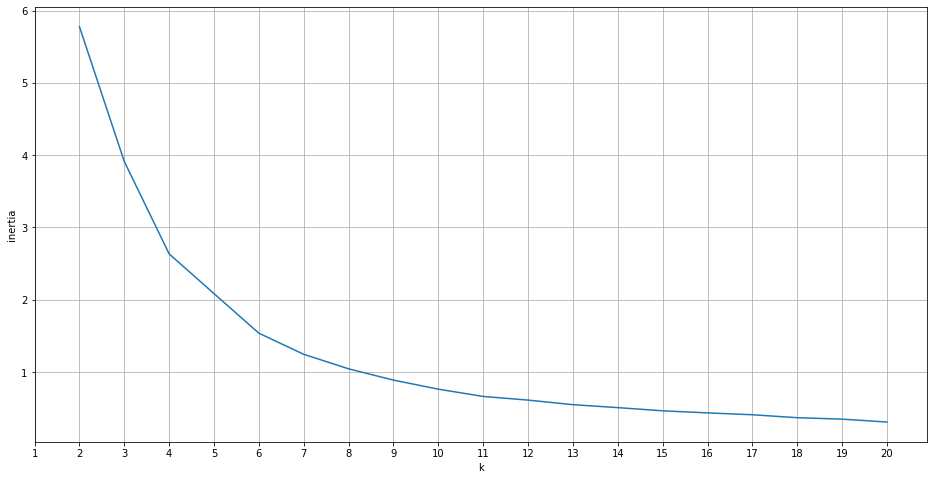

In [87]:
pd.Series({k: ex.get_inertia(k, X) for k in range(2, 21)}).plot()
plt.grid()
plt.xlabel("k")
plt.ylabel("inertia")
plt.xticks(range(1, 21))
plt.show()

## Four Clusters: EI & Total Mortgage Volume

In [88]:
kmeans = KMeans(n_clusters=4, random_state=123)
kmeans.fit(X)

model_df["cluster"] = kmeans.predict(X)

In [89]:
centriods = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centriods

,ei,total_mortgage_volume_pop
0,0.03355,0.06072
1,0.05358,0.27103
2,0.06454,0.58626
3,0.42785,0.14349


In [90]:
model_df.groupby("cluster")["ei", "total_mortgage_volume_pop"].mean()

,ei,total_mortgage_volume_pop
cluster,,
0,0.03355,0.06072
1,0.05358,0.27103
2,0.06454,0.58626
3,0.42785,0.14349


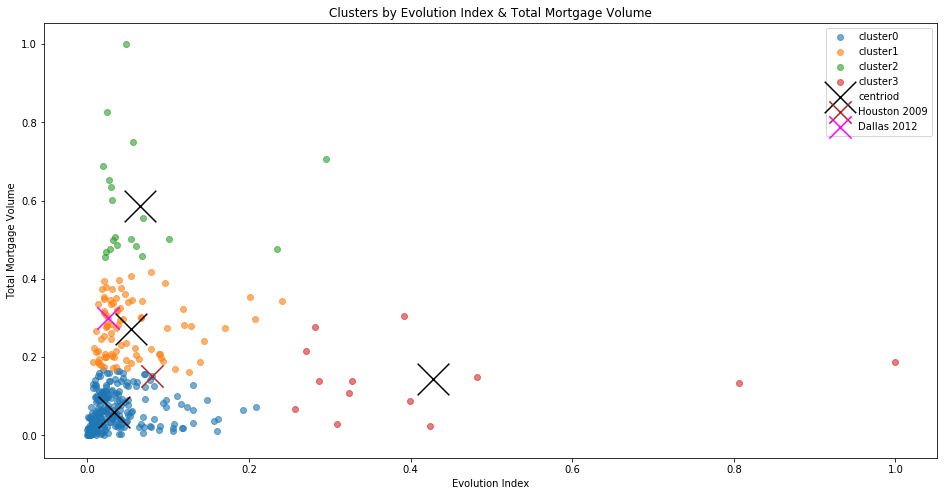

In [91]:
for cluster, subset in model_df.groupby("cluster"):
    plt.scatter(
        subset.ei, subset.total_mortgage_volume_pop, label="cluster" + str(cluster), alpha=0.6
    )

centriods.plot.scatter(
    x="ei",
    y="total_mortgage_volume_pop",
    c="black",
    marker="x",
    s=1000,
    ax=plt.gca(),
    label="centriod",
)

houston_2009 = model_df[(model_df.city == "Houston") & (model_df.state == "TX") & (model_df.year == 2009)]

houston_2009.plot.scatter(
    x="ei",
    y="total_mortgage_volume_pop",
    c="firebrick",
    marker="x",
    s=500,
    ax=plt.gca(),
    label="Houston 2009",
)

dallas_2012 = model_df[(model_df.city == "Dallas") & (model_df.state == "TX")  & (model_df.year == 2012)]

dallas_2012.plot.scatter(
    x="ei",
    y="total_mortgage_volume_pop",
    c="magenta",
    marker="x",
    s=500,
    ax=plt.gca(),
    label="Dallas 2012",
)

plt.legend()
plt.title("Clusters by Evolution Index & Total Mortgage Volume")
plt.xlabel("Evolution Index")
plt.ylabel("Total Mortgage Volume")
plt.show()

---

In [92]:
model_df = pr.get_model_df()

model_df = pr.add_new_features(model_df)

# creating city_state ID
model_df["city_state"] = model_df["city"] + "_" + model_df["state"]

# creating city_mask varible using the value counts of the years for each city_state
city_mask = model_df.groupby("city_state").year.count()

# masking the city_mask variable to only include city_states where there are 15 year observations
# by doing this we ensure that we are working with city_states that have data for 2006-2020 Q2 
city_mask = city_mask[city_mask == 15]

# write a function to shrink the df
def in_city_mask(x):
    return x in city_mask

# apply city mask to shrink the df
model_df = model_df[model_df.city_state.apply(in_city_mask)]

# sort_values of model_df by city, state, and year
model_df = model_df.sort_values(["city", "state", "year"])

# reseting index
model_df.reset_index(inplace=True)

# drop original index
model_df.drop(columns=["index"], inplace=True)

# remove 2006 observations
model_df = model_df[model_df.year > 2006]

print(model_df.shape)
model_df.head(16)

(364, 20)


,city,state,year,quantity_of_mortgages_pop,total_mortgage_volume_pop,average_mortgage_volume_pop,median_mortgage_amount_pop,quantity_of_mortgages_nc,total_mortgage_volume_nc,average_mortgage_volume_nc,median_mortgage_amount_nc,label,city_state_vol_delta_pop,city_state_vol_delta_nc,city_state_qty_delta_pop,city_state_qty_delta_nc,market_volume,market_volume_delta,ei,city_state
1,Atlanta,GA,2007,8,28277600,3534700.00000,3031150.00000,2.00000,4541700.00000,2270850.00000,2270850.00000,False,-0.14793,-0.50532,0.33333,0.00000,4973263164,-0.26584,1.16062,Atlanta_GA
2,Atlanta,GA,2008,2,6735000,3367500.00000,3367500.00000,1.00000,4950000.00000,4950000.00000,4950000.00000,False,-0.76183,0.08990,-0.75000,-0.50000,4444102426,-0.10640,0.26653,Atlanta_GA
3,Atlanta,GA,2009,9,49972900,5552544.44444,4400000.00000,1.00000,3750000.00000,3750000.00000,3750000.00000,False,6.41988,-0.24242,3.50000,0.00000,7882704846,0.77375,4.18317,Atlanta_GA
4,Atlanta,GA,2010,11,68788385,6253489.54545,5196100.00000,2.00000,7203500.00000,3601750.00000,3601750.00000,False,0.37651,0.92093,0.22222,1.00000,16193901958,1.05436,0.67005,Atlanta_GA
5,Atlanta,GA,2011,10,56215900,5621590.00000,4341850.00000,2.00000,9274500.00000,4637250.00000,4637250.00000,False,-0.18277,0.28750,-0.09091,0.00000,17502078323,0.08078,0.75615,Atlanta_GA
6,Atlanta,GA,2012,12,56365900,4697158.33333,3250100.00000,1.00000,3000000.00000,3000000.00000,3000000.00000,False,0.00267,-0.67653,0.20000,-0.50000,21797876931,0.24545,0.80507,Atlanta_GA
7,Atlanta,GA,2013,19,138582800,7293831.57895,6133600.00000,nan,nan,nan,nan,False,1.45863,0.00000,0.58333,0.00000,24940177380,0.14416,2.14886,Atlanta_GA
8,Atlanta,GA,2014,11,106803300,9709390.90909,4919700.00000,1.00000,15861400.00000,15861400.00000,15861400.00000,False,-0.22932,4.28713,-0.42105,0.00000,16405588955,-0.34220,1.17161,Atlanta_GA
9,Atlanta,GA,2015,4,20900000,5225000.00000,5750000.00000,1.00000,5500000.00000,5500000.00000,5500000.00000,False,-0.80431,-0.65325,-0.63636,0.00000,13569931547,-0.17285,0.23658,Atlanta_GA
10,Atlanta,GA,2016,4,27639900,6909975.00000,7350000.00000,1.00000,10350000.00000,10350000.00000,10350000.00000,False,0.32248,0.88182,0.00000,0.00000,15620858461,0.15114,1.14885,Atlanta_GA


In [93]:
scaler = MinMaxScaler()
scaler.fit(model_df[["city_state_vol_delta_pop", "total_mortgage_volume_pop"]])
model_df[["city_state_vol_delta_pop", "total_mortgage_volume_pop"]] = scaler.transform(model_df[["city_state_vol_delta_pop", "total_mortgage_volume_pop"]])

In [94]:
X = model_df[["city_state_vol_delta_pop", "total_mortgage_volume_pop"]]

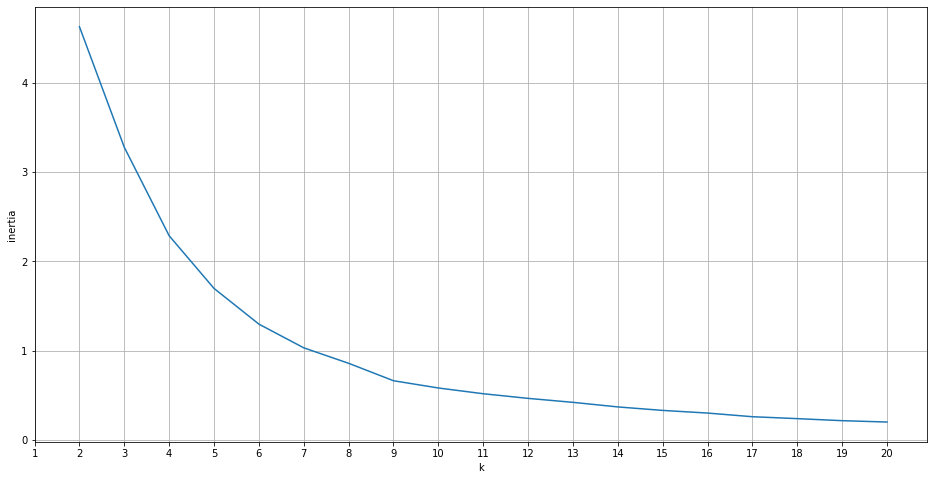

In [95]:
pd.Series({k: ex.get_inertia(k, X) for k in range(2, 21)}).plot()
plt.grid()
plt.xlabel("k")
plt.ylabel("inertia")
plt.xticks(range(1, 21))
plt.show()

## Four Clusters: EI & Total Mortgage Volume

In [96]:
kmeans = KMeans(n_clusters=4, random_state=123)
kmeans.fit(X)

model_df["cluster"] = kmeans.predict(X)

In [97]:
centriods = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centriods

,city_state_vol_delta_pop,total_mortgage_volume_pop
0,0.02681,0.06172
1,0.04450,0.58626
2,0.03399,0.27081
3,0.42504,0.21104


In [98]:
model_df.groupby("cluster")["city_state_vol_delta_pop", "total_mortgage_volume_pop"].mean()

,city_state_vol_delta_pop,total_mortgage_volume_pop
cluster,,
0,0.02681,0.06172
1,0.04450,0.58626
2,0.03399,0.27081
3,0.42504,0.21104


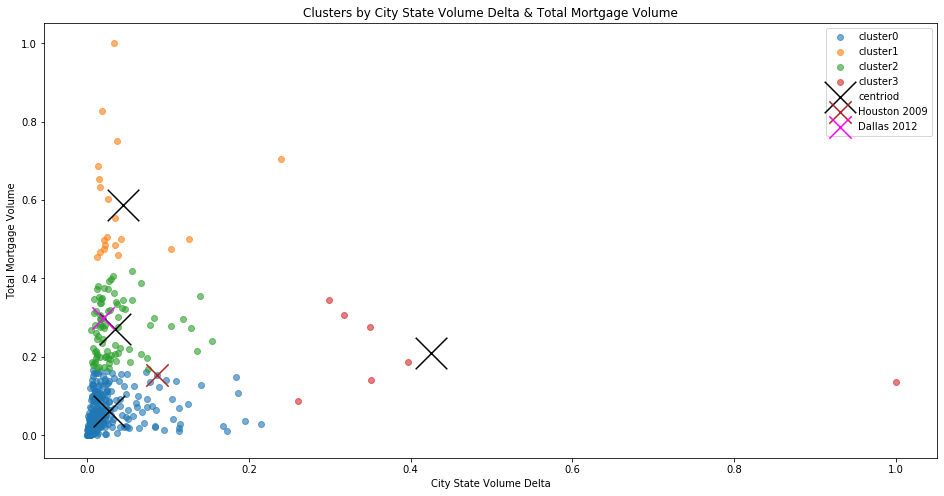

In [99]:
for cluster, subset in model_df.groupby("cluster"):
    plt.scatter(
        subset.city_state_vol_delta_pop, subset.total_mortgage_volume_pop, label="cluster" + str(cluster), alpha=0.6
    )

centriods.plot.scatter(
    x="city_state_vol_delta_pop",
    y="total_mortgage_volume_pop",
    c="black",
    marker="x",
    s=1000,
    ax=plt.gca(),
    label="centriod",
)

houston_2009 = model_df[(model_df.city == "Houston") & (model_df.state == "TX") & (model_df.year == 2009)]

houston_2009.plot.scatter(
    x="city_state_vol_delta_pop",
    y="total_mortgage_volume_pop",
    c="firebrick",
    marker="x",
    s=500,
    ax=plt.gca(),
    label="Houston 2009",
)

dallas_2012 = model_df[(model_df.city == "Dallas") & (model_df.state == "TX")  & (model_df.year == 2012)]

dallas_2012.plot.scatter(
    x="city_state_vol_delta_pop",
    y="total_mortgage_volume_pop",
    c="magenta",
    marker="x",
    s=500,
    ax=plt.gca(),
    label="Dallas 2012",
)

plt.legend()
plt.title("Clusters by City State Volume Delta & Total Mortgage Volume")
plt.xlabel("City State Volume Delta")
plt.ylabel("Total Mortgage Volume")
plt.show()

In [100]:
model_df = pr.get_model_df()

model_df = pr.add_new_features(model_df)

# creating city_state ID
model_df["city_state"] = model_df["city"] + "_" + model_df["state"]

# creating city_mask varible using the value counts of the years for each city_state
city_mask = model_df.groupby("city_state").year.count()

# masking the city_mask variable to only include city_states where there are 15 year observations
# by doing this we ensure that we are working with city_states that have data for 2006-2020 Q2 
city_mask = city_mask[city_mask == 15]

# write a function to shrink the df
def in_city_mask(x):
    return x in city_mask

# apply city mask to shrink the df
model_df = model_df[model_df.city_state.apply(in_city_mask)]

# sort_values of model_df by city, state, and year
model_df = model_df.sort_values(["city", "state", "year"])

# reseting index
model_df.reset_index(inplace=True)

# drop original index
model_df.drop(columns=["index"], inplace=True)

# calculate nc_ratio
model_df["nc_ratio"] = model_df.total_mortgage_volume_nc / model_df.total_mortgage_volume_pop

# fillna in ration feature
model_df.nc_ratio.fillna(value=0, inplace=True)

# remove 2006 observations
model_df = model_df[model_df.year > 2006]

print(model_df.shape)
model_df.head(16)

(364, 21)


,city,state,year,quantity_of_mortgages_pop,total_mortgage_volume_pop,average_mortgage_volume_pop,median_mortgage_amount_pop,quantity_of_mortgages_nc,total_mortgage_volume_nc,average_mortgage_volume_nc,median_mortgage_amount_nc,label,city_state_vol_delta_pop,city_state_vol_delta_nc,city_state_qty_delta_pop,city_state_qty_delta_nc,market_volume,market_volume_delta,ei,city_state,nc_ratio
1,Atlanta,GA,2007,8,28277600,3534700.00000,3031150.00000,2.00000,4541700.00000,2270850.00000,2270850.00000,False,-0.14793,-0.50532,0.33333,0.00000,4973263164,-0.26584,1.16062,Atlanta_GA,0.16061
2,Atlanta,GA,2008,2,6735000,3367500.00000,3367500.00000,1.00000,4950000.00000,4950000.00000,4950000.00000,False,-0.76183,0.08990,-0.75000,-0.50000,4444102426,-0.10640,0.26653,Atlanta_GA,0.73497
3,Atlanta,GA,2009,9,49972900,5552544.44444,4400000.00000,1.00000,3750000.00000,3750000.00000,3750000.00000,False,6.41988,-0.24242,3.50000,0.00000,7882704846,0.77375,4.18317,Atlanta_GA,0.07504
4,Atlanta,GA,2010,11,68788385,6253489.54545,5196100.00000,2.00000,7203500.00000,3601750.00000,3601750.00000,False,0.37651,0.92093,0.22222,1.00000,16193901958,1.05436,0.67005,Atlanta_GA,0.10472
5,Atlanta,GA,2011,10,56215900,5621590.00000,4341850.00000,2.00000,9274500.00000,4637250.00000,4637250.00000,False,-0.18277,0.28750,-0.09091,0.00000,17502078323,0.08078,0.75615,Atlanta_GA,0.16498
6,Atlanta,GA,2012,12,56365900,4697158.33333,3250100.00000,1.00000,3000000.00000,3000000.00000,3000000.00000,False,0.00267,-0.67653,0.20000,-0.50000,21797876931,0.24545,0.80507,Atlanta_GA,0.05322
7,Atlanta,GA,2013,19,138582800,7293831.57895,6133600.00000,nan,nan,nan,nan,False,1.45863,0.00000,0.58333,0.00000,24940177380,0.14416,2.14886,Atlanta_GA,0.00000
8,Atlanta,GA,2014,11,106803300,9709390.90909,4919700.00000,1.00000,15861400.00000,15861400.00000,15861400.00000,False,-0.22932,4.28713,-0.42105,0.00000,16405588955,-0.34220,1.17161,Atlanta_GA,0.14851
9,Atlanta,GA,2015,4,20900000,5225000.00000,5750000.00000,1.00000,5500000.00000,5500000.00000,5500000.00000,False,-0.80431,-0.65325,-0.63636,0.00000,13569931547,-0.17285,0.23658,Atlanta_GA,0.26316
10,Atlanta,GA,2016,4,27639900,6909975.00000,7350000.00000,1.00000,10350000.00000,10350000.00000,10350000.00000,False,0.32248,0.88182,0.00000,0.00000,15620858461,0.15114,1.14885,Atlanta_GA,0.37446


In [101]:
scaler = PowerTransformer()
model_df[["ei", "total_mortgage_volume_pop"]] = scaler.fit_transform(model_df[["ei", "total_mortgage_volume_pop"]])

In [102]:
X = model_df[["ei", "total_mortgage_volume_pop"]]

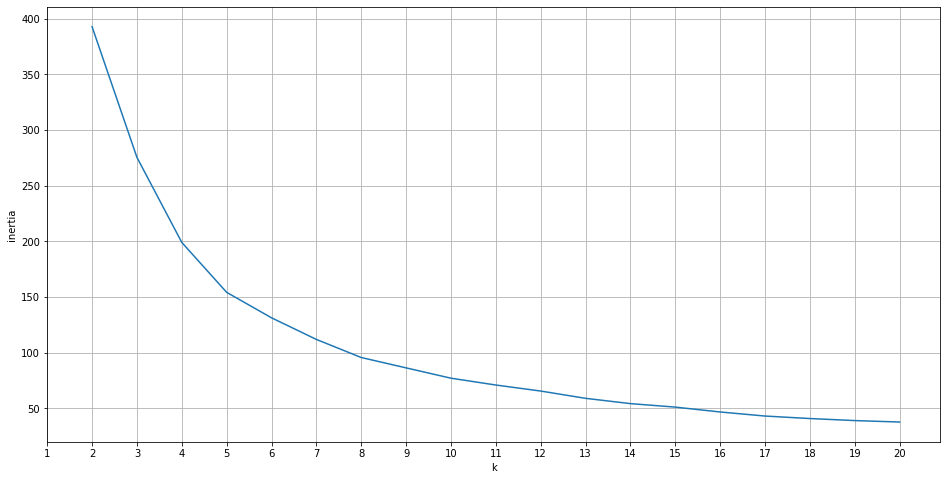

In [103]:
pd.Series({k: ex.get_inertia(k, X) for k in range(2, 21)}).plot()
plt.grid()
plt.xlabel("k")
plt.ylabel("inertia")
plt.xticks(range(1, 21))
plt.show()

In [104]:
kmeans = KMeans(n_clusters=8, random_state=123)
kmeans.fit(X)

model_df["cluster"] = kmeans.predict(X)

In [105]:
centriods = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centriods

,ei,total_mortgage_volume_pop
0,1.39669,-0.64909
1,-0.99899,-0.60059
2,0.49745,0.40132
3,1.57100,0.96827
4,-1.44947,-1.62718
5,0.11402,1.45666
6,-0.58793,0.34461
7,0.15461,-0.63368


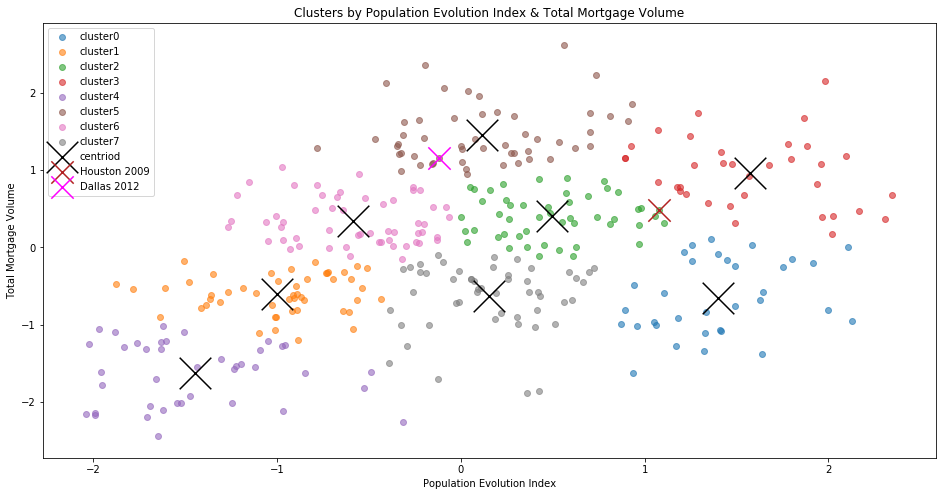

In [106]:
for cluster, subset in model_df.groupby("cluster"):
    plt.scatter(
        subset.ei, subset.total_mortgage_volume_pop, label="cluster" + str(cluster), alpha=0.6
    )

centriods.plot.scatter(
    x="ei",
    y="total_mortgage_volume_pop",
    c="black",
    marker="x",
    s=1000,
    ax=plt.gca(),
    label="centriod",
)

houston_2009 = model_df[(model_df.city == "Houston") & (model_df.state == "TX") & (model_df.year == 2009)]

houston_2009.plot.scatter(
    x="ei",
    y="total_mortgage_volume_pop",
    c="firebrick",
    marker="x",
    s=500,
    ax=plt.gca(),
    label="Houston 2009",
)

# seattle not in dataset
# seattle_2010 = model_df[(model_df.city == "Seattle") & (model_df.state == "WA") & (model_df.year == 2010)]

# seattle_2010.plot.scatter(
#     x="ei",
#     y="nc_ratio",
#     c="purple",
#     marker="x",
#     s=2000,
#     ax=plt.gca(),
#     label="Seattle 2010",
# )

dallas_2012 = model_df[(model_df.city == "Dallas") & (model_df.state == "TX")  & (model_df.year == 2012)]

dallas_2012.plot.scatter(
    x="ei",
    y="total_mortgage_volume_pop",
    c="magenta",
    marker="x",
    s=500,
    ax=plt.gca(),
    label="Dallas 2012",
)

plt.legend()
plt.title("Clusters by Population Evolution Index & Total Mortgage Volume")
plt.xlabel("Population Evolution Index")
plt.ylabel("Total Mortgage Volume")
plt.show()